# Installation & Environment Setup

Below commands illustrate how we install the necessary Python packages and
pull down the Mistral model for Ollama.
The following was run in the terminal:

### 1 Install required Python libraries:
pip install requests pydantic

### 2 Install Ollama if not already done (macOS example):
brew install ollama

### 3 Pull the Mistral model locally:
ollama pull mistral

### 4 Start the Ollama server (in a separate terminal):
ollama serve --model mistral

Once the above is running on port 11434, the subsequent notebook cells can talk to the local LLM.

### 5 Install necessary libraries
pip install requests pydantic 

# Overview

In this notebook, we demonstrate how to:
1. Integrate a locally hosted LLM (Mistral via Ollama) for data transformation.
2. Utilize Pydantic for schema compliance.
3. Transform **Practitioner** records to align with a `users` table structure.
4. Transform **Appointment** records to align with an `appointments` table structure.
5. Provide fallback mechanisms if the LLM fails, ensuring reliable results.
6. Audit transformations, track performance, and handle compliance.

We have already:
- Installed the necessary libraries (`requests`, `pydantic`, etc.).
- Pulled the Mistral model via Ollama (`ollama pull mistral`).
- Started the Ollama server on port 11434.

# Approach followed
"""
This notebook demonstrates two approaches to transforming healthcare data 
(practitioners and appointments) using an LLM (Ollama's Mistral) for partial 
or full schema alignment.

First, we present a simpler, single-entity DataTransformer that only handles 
Practitioner data. We then show its limitations when we try to apply it 
to Appointments.

Next, we progress to a multi-model approach that can handle both Practitioners 
and Appointments with separate classes and more robust logic.
"""

# Imports and Logging

This cell briefly introduces the notebook and imports any necessary libraries.
 We do not repeat these imports elsewhere.

Cell imports all required Python libraries and sets up logging for monitoring the transformation process. Key libraries include:
- **Pydantic**: For schema validation.
- **Requests**: To handle HTTP requests for LLM interactions.
- **Datetime** and **Time**: For timestamping and performance metrics.
- **Logging**: For debugging and auditing.
- **json**: For handling all JSON input and output


In [1]:
import json
import time
import re
import logging
import requests
from datetime import datetime
from typing import List, Optional, Dict, Any, Union
from pydantic import BaseModel, field_validator, ValidationError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Pydantic
from pydantic import BaseModel, field_validator, ValidationError

# Configure logging (prints info-level logs to console)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Auditor & Performance Classes

This cell defines helper classes to support the transformation process:
- **TransformationAuditor**: Logs original and transformed records for compliance and debugging.
- **PerformanceMonitor**: Tracks transformation time, validation time, and error counts.
These classes enable structured logging and performance tracking.


In [2]:
class TransformationAuditor:
    def __init__(self):
        self.audit_records = []

    def log_transformation(self, original: Dict, transformed: Dict, metadata: Dict) -> None:
        audit_record = {
            'timestamp': datetime.now().isoformat(),
            'original_data': original,
            'transformed_data': transformed,
            'transformation_metadata': metadata
        }
        self.audit_records.append(audit_record)
        logging.info(
            f"Transformation audited successfully. "
            f"Method: {metadata.get('method', 'Unknown')}, "
            f"Duration: {metadata.get('duration', 'N/A')} seconds."
        )


class PerformanceMonitor:
    def __init__(self):
        self.metrics = {
            'transformation_times': [],
            'validation_times': [],
            'error_counts': 0,
            'total_records': 0
        }

    def record_transformation_time(self, duration: float):
        self.metrics['transformation_times'].append(duration)
        logging.info(f"Transformation completed in {duration:.2f} seconds.")

    def record_validation_time(self, duration: float):
        self.metrics['validation_times'].append(duration)
        logging.info(f"Validation completed in {duration:.2f} seconds.")

    def record_error(self, error_message: str, record_index: int = None):
        self.metrics['error_counts'] += 1
        logging.error(
            f"Error encountered during transformation. "
            f"Record Index: {record_index if record_index is not None else 'N/A'}, "
            f"Error: {error_message}"
        )

    def record_total_records(self, count: int):
        self.metrics['total_records'] += count
        logging.info(f"Total records to process: {self.metrics['total_records']}.")

    def get_summary(self) -> Dict[str, Any]:
        total_xforms = len(self.metrics['transformation_times'])
        avg_xform_time = (sum(self.metrics['transformation_times']) / total_xforms) if total_xforms else 0

        total_validations = len(self.metrics['validation_times'])
        avg_validation_time = (sum(self.metrics['validation_times']) / total_validations) if total_validations else 0

        logging.info(
            f"Performance Summary: "
            f"Total Transformations: {total_xforms}, "
            f"Average Transformation Time: {avg_xform_time:.2f} seconds, "
            f"Average Validation Time: {avg_validation_time:.2f} seconds, "
            f"Error Count: {self.metrics['error_counts']}."
        )

        return {
            'total_transformations': total_xforms,
            'avg_transformation_time': avg_xform_time,
            'avg_validation_time': avg_validation_time,
            'error_counts': self.metrics['error_counts']
        }



# OllamaHandler (Local LLM Integration)

This cell implements the `OllamaHandler` class to interact with the locally running Mistral model via HTTP requests.
- **Functions**:
  - `test_connection`: Checks if the Mistral server is accessible.
  - `generate`: Sends a prompt to the Mistral LLM and retrieves the response.
- Ensures robust error handling during LLM interactions.


In [3]:
class OllamaHandler:
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        try:
            self.test_connection()
            print("Successfully connected to Ollama (Mistral).")
        except Exception as e:
            print(f"Warning: Could not connect to Ollama: {str(e)}")
            raise

    def test_connection(self):
        response = requests.post(
            self.api_url, 
            json={"model": "mistral", "prompt": "test", "stream": False}
        )
        response.raise_for_status()

    def generate(self, prompt: str) -> str:
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        response = requests.post(self.api_url, json=payload)
        response.raise_for_status()
        return response.json()['response']
    

# SinglePractitionerRecord for Practitioners

Defines the schema for transformed practitioner records using Pydantic.

This cell defines the `UserRecord` class, a Pydantic model for validating practitioner records.
- Ensures schema compliance with the `users` table.
- Validates specific fields like `title` (removes trailing periods and checks valid values).
- Omits fields not relevant to practitioner transformations.


In [4]:
class TransformedRecord(BaseModel):
    """
    Pydantic model for transformed practitioner records.
    """
    id: int
    first_name: str
    last_name: str
    practice_id: int
    title: Optional[str] = None
    email: Optional[str] = None
    gender: Optional[str] = None
    type: Optional[str] = None
    status: Optional[int] = None
    online: Optional[bool] = None
    employment_status: Optional[str] = None
    service_type_id: Optional[int] = None
    commission_flat_rate: Optional[int] = None
    commission_percent: Optional[int] = None
    time_slot: Optional[int] = None
    location_ids: Optional[List[int]] = None
    default_location_id: Optional[int] = None
    location_name: Optional[str] = None
    address_line_1: Optional[str] = None
    address_line_2: Optional[str] = None
    town_city: Optional[str] = None
    state_county: Optional[str] = None
    postcode_zipcode: Optional[str] = None
    country: Optional[str] = None
    phone_number: Optional[str] = None
    mobile: Optional[str] = None
    online_guid: Optional[str] = None
    skills: Optional[List[str]] = []

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate the title field:
        - Remove trailing periods.
        - Ensure the value is within the list of valid titles.
        """
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr', 'Lady',
                        'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        if clean_title not in valid_titles:
            logging.warning(f"Invalid title detected: {v}. Setting to None.")
            return None
        return clean_title

    @field_validator('email')
    def validate_email(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate the email field:
        - Ensure it contains '@' and a domain, or set it to None.
        """
        if v and '@' not in v:
            logging.warning(f"Invalid email detected: {v}. Setting to None.")
            return None
        return v

    @field_validator('mobile', 'phone_number')
    def validate_phone(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate phone number fields:
        - Remove non-digit characters.
        """
        if v:
            clean_phone = ''.join(filter(str.isdigit, v))
            if len(clean_phone) < 10:
                logging.warning(f"Invalid phone number detected: {v}. Setting to None.")
                return None
            return clean_phone
        return None

    @field_validator('skills')
    def validate_skills(cls, v: Optional[List[str]]) -> Optional[List[str]]:
        """
        Validate the skills field:
        - Ensure all elements are strings.
        - Remove empty strings from the list.
        """
        if v:
            clean_skills = [skill for skill in v if isinstance(skill, str) and skill.strip()]
            if not clean_skills:
                logging.info("Skills field is empty or invalid. Setting to None.")
                return None
            return clean_skills
        return None

    @field_validator('postcode_zipcode')
    def validate_postcode(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate the postcode/zipcode:
        - Ensure it's alphanumeric.
        """
        if v and not v.replace(' ', '').isalnum():
            logging.warning(f"Invalid postcode detected: {v}. Setting to None.")
            return None
        return v


# Appointment Pydantic Model
This cell defines the `AppointmentRecord` class, a Pydantic model for validating appointment records.
- Ensures schema compliance with the `appointments` table.
- Handles complex fields such as `start_time`, `end_time`, and `status`.
- Provides field-level validation and fallback mechanisms for appointment-specific fields.


In [5]:
class AppointmentRecord(BaseModel):
    """
    Pydantic model for validating appointment records.
    Ensures schema compliance with the 'appointments' table.
    """

    id: int
    location_id: Optional[int] = None
    patient_id: int
    practitioner_id: Optional[int] = None
    start_time: Optional[str] = None  
    end_time: Optional[str] = None
    status: str
    title: Optional[str] = None
    description: Optional[str] = None

    @field_validator("title")
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate the title field:
        - Remove trailing periods.
        - Ensure value is within the valid titles list.
        """
        if not v:
            return None
        valid_titles = ["Mr", "Mrs", "Miss", "Ms", "Mx", "Sir", "Dr", "Lady", "Lord", "Master", "Prof", "Other"]
        clean_title = v.rstrip(".")
        if clean_title not in valid_titles:
            return None
        return clean_title

    @field_validator("start_time", "end_time")
    def validate_time_format(cls, v: Optional[str]) -> Optional[str]:
        """
        Validate the start_time and end_time fields:
        - Ensure they are in a valid datetime string format.
        """
        if v:
            from datetime import datetime
            try:
                # Try ISO 8601 format first (with "T" separator).
                datetime.fromisoformat(v)
            except ValueError:
                # Fallback to the original format if ISO fails.
                try:
                    datetime.strptime(v, "%Y-%m-%d %H:%M:%S")
                except ValueError:
                    raise ValueError(f"Invalid datetime format: {v}")
        return v


 # DataTransformer Class
This class handles the transformation of practitioner data

This cell implements the `PractitionerTransformer` class:
- Transforms practitioner records from JSON into the `UserRecord` schema.
- Uses the LLM (via `OllamaHandler`) for schema mapping.
- Provides a fallback mechanism for manual transformations when LLM output is invalid.
- Tracks performance metrics and audits transformations.


In [6]:
class DataTransformer:
    def __init__(self):
        self.llm = OllamaHandler()

    def get_transformation_prompt(self, record: Dict) -> str:
        schema_example = {
            "id": "integer (keep original)",
            "first_name": "from forename",
            "last_name": "from surname",
            "practice_id": "from defaultLocationId",
            "title": "title without period",
            "email": "string",
            "gender": "string",
            "type": "string",
            "status": "integer",
            "online": "boolean",
            "employment_status": "from employmentStatus",
            "service_type_id": "from serviceTypeId",
            "commission_flat_rate": "integer",
            "commission_percent": "integer",
            "time_slot": "integer",
            "location_ids": "array of integers",
            "location_name": "string",
            "address_line_1": "parse from fullAddress",
            "address_line_2": "parse from fullAddress",
            "town_city": "parse from fullAddress",
            "state_county": "parse from fullAddress",
            "postcode_zipcode": "from postCode",
            "country": "parse from fullAddress",
            "mobile": "string",
            "online_guid": "string",
            "skills": "array"
        }

        return f"""Transform this healthcare practitioner record to exactly match the schema format.
Input Record:
{json.dumps(record, indent=2)}

Required Schema:
{json.dumps(schema_example, indent=2)}

Rules:
1. Keep all IDs and numerical values exactly as they appear
2. Parse the address from '{record.get('fullAddress', '')}' into components
3. Remove any trailing periods from title
4. Return ONLY as valid JSON matching the schema format
5. Only include fields that have values (omit null/empty)

Return the transformed data as a single JSON object."""

    def transform_record(self, record: Dict) -> Dict:
        prompt = self.get_transformation_prompt(record)
        try:
            llm_response = self.llm.generate(prompt)
            start = llm_response.find('{')
            end = llm_response.rfind('}') + 1
            if start >= 0 and end > start:
                json_str = llm_response[start:end]
                transformed = json.loads(json_str)
                transformed['id'] = record['id']
                transformed['first_name'] = record['forename']
                transformed['last_name'] = record['surname']
                transformed['practice_id'] = record['defaultLocationId']
                validated = TransformedRecord(**transformed)
                return validated.model_dump(exclude_none=True)
            else:
                raise ValueError("No valid JSON found in LLM response")
        except Exception as e:
            print(f"LLM transformation failed: {str(e)}")
            print("Falling back to basic transformation")
            return self.transform_record_fallback(record)

    def transform_record_fallback(self, record: Dict) -> Dict:
        transformed = {
            'id': record['id'],
            'first_name': record['forename'],
            'last_name': record['surname'],
            'practice_id': record['defaultLocationId'],
            'title': record.get('title', '').rstrip('.'),
            'email': record.get('email'),
            'gender': record.get('gender'),
            'type': record.get('type'),
            'status': record.get('status'),
            'online': record.get('online'),
            'employment_status': record.get('employmentStatus'),
            'service_type_id': record.get('serviceTypeId'),
            'location_ids': record.get('locationIds'),
            'location_name': record.get('locationName'),
            'mobile': record.get('mobile'),
            'online_guid': record.get('onlineGuid')
        }

        if record.get('fullAddress'):
            parts = [p.strip() for p in record['fullAddress'].split(',')]
            if len(parts) >= 1: transformed['address_line_1'] = parts[0]
            if len(parts) >= 2: transformed['address_line_2'] = parts[1]
            if len(parts) >= 3: transformed['town_city'] = parts[2]
            if len(parts) >= 4: transformed['state_county'] = parts[3]
            if len(parts) >= 5: transformed['country'] = parts[-1]
        if record.get('postCode'):
            transformed['postcode_zipcode'] = record['postCode']
        return transformed

    def transform_data(self, input_records: List[Dict]) -> List[Dict]:
        transformed_records = []
        for i, record in enumerate(input_records, 1):
            print(f"Processing record {i}/{len(input_records)}")
            try:
                transformed = self.transform_record(record)
                transformed_records.append(transformed)
                print(f"Successfully transformed record {i}")
            except Exception as e:
                print(f"Error processing record {i}: {str(e)}")
                continue
        return transformed_records


# AppointmentTransformer 

This cell implements the `AppointmentTransformer` class:
- Transforms appointment records from JSON into the `AppointmentRecord` schema.
- Uses the LLM for handling complex field mapping.
- Provides a fallback mechanism for manual transformations.
- Logs transformations and tracks performance metrics.


In [7]:
class AppointmentTransformer:
    """
    Transforms appointment records from JSON into the AppointmentRecord schema.
    Uses LLM for complex field mapping and provides a fallback mechanism.
    Logs transformations and tracks performance metrics.
    """

    def __init__(self, auditor, performance_monitor):
        self.llm = OllamaHandler()
        self.auditor = auditor
        self.performance_monitor = performance_monitor

    def _map_status(self, status_code: Optional[int]) -> str:
        """
        Map status integers to ENUM values as per the database schema.
        """
        status_mapping = {
            1: 'draft',
            2: 'completed',
            3: 'Arrived',
            4: 'Did Not Arrive'
        }
        return status_mapping.get(status_code, 'draft')

    def _get_prompt(self, record: Dict[str, Any]) -> str:
        """
        Generate the LLM prompt for transforming an appointment record.
        """
        example_before = {
            "id": 282697,
            "startDateTime": "30/06/2016 00:52:40",
            "endDateTime": "30/06/2016 01:52:40",
            "customerId": 626189,
            "practitionerId": 960689,
            "locationId": 840971,
            "status": 2,
            "title": "Dr.",
            "comment": "Follow-up consultation"
        }
        example_after = {
            "id": 282697,
            "location_id": 840971,
            "patient_id": 626189,
            "practitioner_id": 960689,
            "status": "completed",
            "start_time": "30/06/2016 00:52:40",
            "end_time": "30/06/2016 01:52:40",
            "title": "Dr",
            "description": "Follow-up consultation"
        }

        return f"""
Transform the following appointment record to match the database schema strictly in valid JSON format:

Example Input:
{json.dumps(example_before, indent=2)}

Example Output:
{json.dumps(example_after, indent=2)}

Record to Transform:
{json.dumps(record, indent=2)}

Rules:
1. Return strictly valid JSON with double quotes and no extra text.
2. Map status codes (e.g., 2) to ENUM strings (e.g., 'completed').
3. Use the schema fields: id, location_id, patient_id, practitioner_id, status, start_time, end_time, title, description.
4. Remove trailing '.' from title, or set title to null if invalid.
"""

    def transform_record_llm(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Use the LLM to transform a single appointment record.
        """
        prompt = self._get_prompt(record)
        for attempt in range(2):  # Retry mechanism for LLM output
            llm_response = self.llm.generate(prompt)

            try:
                # Extract JSON from the LLM response
                json_str = llm_response.strip()
                start_idx = json_str.find('{')
                end_idx = json_str.rfind('}') + 1
                if start_idx >= 0 and end_idx > start_idx:
                    json_str = json_str[start_idx:end_idx]
                    transformed = json.loads(json_str)

                    # Map status to ENUM string
                    if "status" in transformed:
                        transformed["status"] = self._map_status(transformed["status"])
                    return transformed
                else:
                    raise ValueError("No valid JSON structure in LLM response.")
            except json.JSONDecodeError as e:
                logging.error(f"Error parsing LLM response on attempt {attempt + 1}: {str(e)}")
                if attempt == 1:  # Log final failure before fallback
                    raise ValueError(f"Error parsing LLM response after retries: {str(e)}")

    def transform_record_fallback(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Manual fallback transformation for an appointment record.
        """
        transformed = {
            "id": record.get("id"),
            "location_id": record.get("locationId"),
            "patient_id": record.get("customerId"),
            "practitioner_id": record.get("practitionerId"),
            "status": self._map_status(record.get("status", 1)),
            "start_time": record.get("startDateTime"),
            "end_time": record.get("endDateTime"),
            "title": record.get("title", "").rstrip('.') if record.get("title") else None,
            "description": record.get("description") or record.get("comment"),
        }
        return {key: (value if value else None) for key, value in transformed.items()}

    def transform_record(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Transform a single appointment record, with LLM and fallback.
        """

        start_time = time.time()
        try:
            llm_output = self.transform_record_llm(record)
            validation_start = time.time()
            validated = AppointmentRecord(**llm_output)
            validation_end = time.time()

            self.performance_monitor.record_validation_time(validation_end - validation_start)
            final_data = validated.model_dump(exclude_none=True)
            end_time = time.time()

            self.performance_monitor.record_transformation_time(end_time - start_time)
            self.auditor.log_transformation(record, final_data, {"method": "LLM"})
            return final_data

        except Exception as e:
            error_message = str(e)
            logging.error(f"LLM failed: {error_message}. Using fallback.")
            self.performance_monitor.record_error(error_message=error_message)
            fallback_data = self.transform_record_fallback(record)

            try:
                validated = AppointmentRecord(**fallback_data)
                final_data = validated.model_dump(exclude_none=True)
            except ValidationError as ve:
                error_message = str(ve)
                logging.error(f"Fallback validation failed: {error_message}")
                self.performance_monitor.record_error(error_message=error_message)
                final_data = fallback_data

            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)
            self.auditor.log_transformation(record, final_data, {"method": "Fallback"})
            return final_data

    def transform_data(self, records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Transform multiple appointment records.
        """
        results = []
        for i, record in enumerate(records, 1):
            logging.info(f"Processing appointment record {i}/{len(records)}")
            try:
                transformed_record = self.transform_record(record)
                results.append(transformed_record)
                logging.info(f"Successfully processed record {i}/{len(records)}")
            except Exception as e:
                error_message = str(e)
                logging.error(f"Error processing record {i}: {error_message}")
                self.performance_monitor.record_error(error_message=error_message, record_index=i)
                continue
        return results


In [8]:
# Centralized log storage
combined_logs = []

# Log function
def log_transformation(record_id, method, success, time_taken, stage, error=None):
    """Utility function to log transformation details."""
    combined_logs.append({
        "record_id": record_id,
        "method": method,
        "success": success,
        "time": time_taken,
        "stage": stage,
        "error": error
    })

def main():
    with open('client_data.json', 'r') as f:
        input_data = json.load(f)

    start_time = time.time()
    transformer = DataTransformer()
    transformed_data = transformer.transform_data(input_data['results'])
    processing_time = time.time() - start_time

    # Log for each record
    for idx, record in enumerate(transformed_data, start=1):
        log_transformation(
            record_id=record.get("id", idx),
            method="LLM",  
            success=True,  
            time_taken=processing_time / len(transformed_data),  
            stage="main",
            error=None  
        )

    with open('transformed_output.json', 'w') as f:
        json.dump(transformed_data, f, indent=2)

    print("\nSample transformed record:")
    print(json.dumps(transformed_data[:2], indent=2))
    return transformed_data

if __name__ == "__main__":
    transformed_data = main()


Successfully connected to Ollama (Mistral).
Processing record 1/3
Successfully transformed record 1
Processing record 2/3
Successfully transformed record 2
Processing record 3/3


2025-01-13 13:44:29,557 - WARNING - Invalid title detected: ProfClarke. Setting to None.


Successfully transformed record 3

Sample transformed record:
[
  {
    "id": 808656,
    "first_name": "Mandy",
    "last_name": "Thompson",
    "practice_id": 932896,
    "title": "Ms",
    "email": "louis.mitchell@example.org",
    "gender": "Female",
    "type": "Owner",
    "status": 1,
    "online": true,
    "employment_status": "Owner",
    "service_type_id": 1,
    "commission_flat_rate": 0,
    "commission_percent": 0,
    "time_slot": 0,
    "location_ids": [
      932896
    ],
    "location_name": "Marshall Ltd",
    "address_line_1": "Flat 49\nStacey Junction",
    "town_city": "South Peter",
    "state_county": "Cambridgeshire",
    "postcode_zipcode": "NG24 2PB",
    "country": "Northern Ireland",
    "mobile": "07533808703",
    "online_guid": "5c2e5024-a33f-34b0-9da5-6446d2e3e466"
  },
  {
    "id": 678669,
    "first_name": "Lizzie",
    "last_name": "Brown",
    "practice_id": 771115,
    "title": "Miss",
    "email": "uhughes@example.net",
    "gender": "Male",
   

Testing Single Approach on Appointments
# This cell demonstrates the limitations of the single-practitioner approach when applied to appointment records.

In [9]:
combined_logs = []

def log_transformation(record_id, method, success, time_taken, stage, error=None):
    """Utility function to log transformation details."""
    combined_logs.append({
        "record_id": record_id,
        "method": method,
        "success": success,
        "time": time_taken,
        "stage": stage,
        "error": error
    })

def main_single_appointments():
    with open('appointments_data.json', 'r') as f:
        data = json.load(f)
    records = data['results'][:5]

    auditor = TransformationAuditor()
    performance_monitor = PerformanceMonitor()
    transformer = AppointmentTransformer(auditor=auditor, performance_monitor=performance_monitor)

    start_time = time.time()
    transformed = transformer.transform_data(records)
    processing_time = time.time() - start_time

    # Log each record
    for idx, record in enumerate(transformed, start=1):
        method = "LLM" if "online_guid" in record else "Fallback"
        success = "error" not in record  
        error_message = record.get("error", None) if not success else None
        log_transformation(
            record_id=record.get("id", idx),
            method=method,
            success=success,
            time_taken=processing_time / len(records),
            stage="main_single_appointments",
            error=error_message
        )

    print(f"\nProcessed {len(records)} appointment records in {processing_time:.2f} seconds.")
    return transformed

if __name__ == "__main__":
    transformed_appointments = main_single_appointments()


2025-01-13 13:44:35,675 - INFO - Processing appointment record 1/5


Successfully connected to Ollama (Mistral).


2025-01-13 13:44:55,628 - INFO - Validation completed in 0.00 seconds.
2025-01-13 13:44:55,631 - INFO - Transformation completed in 19.95 seconds.
2025-01-13 13:44:55,632 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 13:44:55,635 - INFO - Successfully processed record 1/5
2025-01-13 13:44:55,636 - INFO - Processing appointment record 2/5
2025-01-13 13:45:18,910 - ERROR - Error parsing LLM response on attempt 1: Expecting property name enclosed in double quotes: line 9 column 20 (char 216)
2025-01-13 13:45:35,487 - INFO - Validation completed in 0.00 seconds.
2025-01-13 13:45:35,488 - INFO - Transformation completed in 39.85 seconds.
2025-01-13 13:45:35,489 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 13:45:35,489 - INFO - Successfully processed record 2/5
2025-01-13 13:45:35,490 - INFO - Processing appointment record 3/5
2025-01-13 13:45:50,725 - INFO - Validation completed in 0.00 seconds.
2


Processed 5 appointment records in 115.91 seconds.


In [168]:
combined_logs = []

def log_transformation(record_id, method, success, time_taken, stage, error=None):
    """Utility function to log transformation details."""
    combined_logs.append({
        "record_id": record_id,
        "method": method,
        "success": success,
        "time": time_taken,
        "stage": stage,
        "error": error
    })

def main_single_appointments():
    with open('appointments_data.json', 'r') as f:
        data = json.load(f)
    records = data['results'][5:16]

    auditor = TransformationAuditor()
    performance_monitor = PerformanceMonitor()
    transformer = AppointmentTransformer(auditor=auditor, performance_monitor=performance_monitor)

    start_time = time.time()
    transformed = transformer.transform_data(records)
    processing_time = time.time() - start_time

    # Log each record
    for idx, record in enumerate(transformed, start=1):
        method = "LLM" if "online_guid" in record else "Fallback"
        success = "error" not in record  
        error_message = record.get("error", None) if not success else None
        log_transformation(
            record_id=record.get("id", idx),
            method=method,
            success=success,
            time_taken=processing_time / len(records),
            stage="main_single_appointments",
            error=error_message
        )

    print(f"\nProcessed {len(records)} appointment records in {processing_time:.2f} seconds.")
    return transformed

if __name__ == "__main__":
    transformed_appointments = main_single_appointments()


2025-01-06 08:45:15,445 - INFO - Processing appointment record 1/11


Successfully connected to Ollama (Mistral).


2025-01-06 08:45:43,207 - INFO - Validation completed in 0.00 seconds.
2025-01-06 08:45:43,209 - INFO - Transformation completed in 27.76 seconds.
2025-01-06 08:45:43,209 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-06 08:45:43,210 - INFO - Successfully processed record 1/11
2025-01-06 08:45:43,211 - INFO - Processing appointment record 2/11
2025-01-06 08:46:00,620 - ERROR - Error parsing LLM response on attempt 1: Expecting value: line 9 column 12 (char 207)
2025-01-06 08:46:21,807 - ERROR - Error parsing LLM response on attempt 2: Expecting value: line 9 column 12 (char 207)
2025-01-06 08:46:21,809 - ERROR - LLM failed: Error parsing LLM response after retries: Expecting value: line 9 column 12 (char 207). Using fallback.
2025-01-06 08:46:21,810 - ERROR - Error encountered during transformation. Record Index: N/A, Error: Error parsing LLM response after retries: Expecting value: line 9 column 12 (char 207)
2025-01-06 08:46:21,814 - INFO - 


Processed 11 appointment records in 277.11 seconds.


# Observations & Transition
"""
### Observations

1. The single-practitioner approach transforms basic practitioner records correctly.
   - Example: First name, last name, title, and practice ID are properly handled.
2. When applied to appointment records, the approach fails to handle:
   - Fields such as startDateTime and endDateTime.
   - Complex appointment-specific fields like location, status, and description.
3. The fallback mechanism ensures basic schema compliance, but it cannot manage the nuanced transformations required for appointments.

### Transition
To address these limitations, we introduce a **multi-model approach**, which includes:
- A PractitionerTransformer for practitioner records.
- An AppointmentTransformer for appointment records.

This approach allows:
- Schema-specific handling.
- Improved error management.
- Scalability to diverse healthcare data types.

In the next cells, we will implement and demonstrate this advanced multi-model solution.
"""


# Practitioner Transformer

This cell defines the `PractitionerTransformer` class, which:
- Transforms practitioner records from the JSON format to align with the `users` table schema.
- Uses the LLM (via `OllamaHandler`) to perform schema-specific transformations.
- Implements a fallback mechanism for manual mapping in case the LLM fails.
- Logs transformations and monitors performance using shared classes.


In [18]:
class PractitionerTransformer:
    """
    Handles transformation of practitioner records to align with 'users' table.
    """
    def __init__(self, auditor, performance_monitor):
        self.llm = OllamaHandler()
        self.auditor = auditor
        self.performance_monitor = performance_monitor

    def _get_prompt(self, record: Dict[str, Any]) -> str:
        """
        Generates a prompt for transforming practitioner records.
        """
        schema_doc = {
            "id": "int",
            "title": "enum string, remove trailing period",
            "first_name": "from forename",
            "last_name": "from surname",
            "email": "string or null",
            "practice_id": "from defaultLocationId or null",
        }
        return f"""
Transform this practitioner record into 'users' table format:
{json.dumps(record, indent=2)}

Schema:
{json.dumps(schema_doc, indent=2)}

Rules:
1. Only include fields in the schema.
2. Remove trailing '.' from title.
3. Set missing or empty fields to null.
4. Return valid JSON.
        """

    def transform_record_llm(self, record: Dict[str, Any]) -> Dict[str, Any]:
        prompt = self._get_prompt(record)
        response = self.llm.generate(prompt)
        start = response.find('{')
        end = response.rfind('}') + 1
        if start >= 0 and end > start:
            return json.loads(response[start:end])
        raise ValueError("Invalid LLM response")

    def transform_record_fallback(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Manual fallback for practitioner record transformation.
        """
        return {
            "id": record.get("id"),
            "title": (record.get("title") or "").rstrip('.'),
            "first_name": record.get("forename"),
            "last_name": record.get("surname"),
            "email": record.get("email"),
            "practice_id": record.get("defaultLocationId"),
        }

    def transform_record(self, record: Dict[str, Any]) -> Dict[str, Any]:
        try:
            llm_result = self.transform_record_llm(record)
            validated = TransformedRecord(**llm_result)
            self.auditor.log_transformation(record, validated.model_dump(), {"method": "LLM"})
            return validated.model_dump()
        except Exception as e:
            logging.error(f"LLM failed: {e}. Using fallback.")
            fallback_result = self.transform_record_fallback(record)
            validated = TransformedRecord(**fallback_result)
            self.auditor.log_transformation(record, validated.model_dump(), {"method": "Fallback"})
            return validated.model_dump()

    def transform_data(self, records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        return [self.transform_record(record) for record in records]


# Appointment Transformer

This cell defines the `AppointmentTransformer` class, which:
- Handles transformation of appointment records to align with the `appointments` table schema.
- Uses LLMs for complex field mapping and a fallback mechanism for manual transformations.
- Supports fields such as `startDateTime`, `endDateTime`, and `description`.
- Includes compliance checks, error handling, and performance monitoring.


In [20]:
class AppointmentTransformer:
    """
    Transforms appointment records from JSON into the AppointmentRecord schema.
    Uses LLM for complex field mapping and provides a fallback mechanism.
    Logs transformations and tracks performance metrics.
    """

    def __init__(self, auditor, performance_monitor):
        self.llm = OllamaHandler()
        self.auditor = auditor
        self.performance_monitor = performance_monitor

    def _map_status(self, status_code: Optional[int]) -> str:
        """
        Map status integers to ENUM values as per the database schema.
        """
        status_mapping = {
            1: 'draft',
            2: 'completed',
            3: 'Arrived',
            4: 'Did Not Arrive'
        }
        return status_mapping.get(status_code, 'draft')

    def _get_prompt(self, record: Dict[str, Any]) -> str:
        """
        Generate the LLM prompt for transforming an appointment record.
        """
        example_before = {
            "id": 282697,
            "startDateTime": "30/06/2016 00:52:40",
            "endDateTime": "30/06/2016 01:52:40",
            "customerId": 626189,
            "practitionerId": 960689,
            "locationId": 840971,
            "status": 2,
            "title": "Dr.",
            "comment": "Follow-up consultation"
        }
        example_after = {
            "id": 282697,
            "location_id": 840971,
            "patient_id": 626189,
            "practitioner_id": 960689,
            "status": "completed",
            "start_time": "30/06/2016 00:52:40",
            "end_time": "30/06/2016 01:52:40",
            "title": "Dr",
            "description": "Follow-up consultation"
        }

        schema_doc = {
            "id": "int",
            "location_id": "bigint or null",
            "patient_id": "bigint not null",
            "practitioner_id": "bigint or null",
            "status": "enum string ('draft', 'completed', 'Arrived', 'Did Not Arrive')",
            "start_time": "datetime string, from startDateTime",
            "end_time": "datetime string, from endDateTime",
            "title": "remove trailing period, or null",
            "description": "from 'comment' if present"
        }

        return f"""
Transform this appointment record into the 'appointments' table format:

Example:
BEFORE:
{json.dumps(example_before, indent=2)}
AFTER:
{json.dumps(example_after, indent=2)}

Now transform the following record:
{json.dumps(record, indent=2)}

Schema:
{json.dumps(schema_doc, indent=2)}

Rules:
1. If field is missing or empty, set it to null.
2. Only include fields in the schema (drop everything else).
3. Remove trailing '.' from title if present.
4. Map status integers to ENUM strings.
5. Return strictly valid JSON, omitting extra text.
"""

    def transform_record_llm(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Use the LLM to transform a single appointment record.
        """
        prompt = self._get_prompt(record)
        llm_response = self.llm.generate(prompt)

        try:
            # Extract valid JSON block from response
            json_pattern = r'{.*}'
            match = re.search(json_pattern, llm_response, re.DOTALL)
            if not match:
                raise ValueError("No valid JSON found in LLM response")
            raw_json = match.group()

            # Remove comments and validate JSON
            clean_json = re.sub(r'//.*', '', raw_json)
            transformed = json.loads(clean_json)

            # Map status to ENUM
            if "status" in transformed:
                transformed["status"] = self._map_status(transformed["status"])
            return transformed
        except json.JSONDecodeError as e:
            logging.error(f"Invalid JSON in LLM response: {str(e)}")
            raise ValueError(f"Invalid JSON in LLM response: {str(e)}")
        except Exception as e:
            logging.error(f"Error parsing LLM response: {str(e)}")
            raise ValueError(f"Error parsing LLM response: {str(e)}")

    def transform_record_fallback(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Manual fallback transformation for an appointment record.
        """
        transformed = {
            "id": record.get("id"),
            "location_id": record.get("locationId"),
            "patient_id": record.get("customerId"),
            "practitioner_id": record.get("practitionerId"),
            "status": self._map_status(record.get("status", 1)),
            "start_time": record.get("startDateTime"),
            "end_time": record.get("endDateTime"),
            "title": record.get("title", "").rstrip('.') if record.get("title") else None,
            "description": record.get("comment"),
        }
        return {key: (value if value else None) for key, value in transformed.items()}

    def transform_record(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Transform a single appointment record, using LLM and fallback.
        """
        start_time = time.time()
        try:
            llm_output = self.transform_record_llm(record)
            validation_start = time.time()
            validated = AppointmentRecord(**llm_output)
            validation_end = time.time()

            self.performance_monitor.record_validation_time(validation_end - validation_start)
            final_data = validated.model_dump(exclude_none=True)
            end_time = time.time()

            self.performance_monitor.record_transformation_time(end_time - start_time)
            self.auditor.log_transformation(record, final_data, {"method": "LLM"})
            return final_data

        except Exception as e:
            logging.error(f"LLM failed: {str(e)}. Using fallback.")
            self.performance_monitor.record_error(error_message=str(e))
            fallback_data = self.transform_record_fallback(record)

            try:
                validated = AppointmentRecord(**fallback_data)
                final_data = validated.model_dump(exclude_none=True)
            except ValidationError as ve:
                logging.error(f"Fallback validation failed: {str(ve)}")
                self.performance_monitor.record_error(error_message=str(ve))
                final_data = fallback_data

            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)
            self.auditor.log_transformation(record, final_data, {"method": "Fallback"})
            return final_data

    def transform_data(self, records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Transform multiple appointment records.
        """
        results = []
        for i, record in enumerate(records, start=1):
            logging.info(f"Processing appointment record {i}/{len(records)}")
            try:
                transformed_record = self.transform_record(record)
                results.append(transformed_record)
                logging.info(f"Successfully processed record {i}/{len(records)}")
            except Exception as e:
                logging.error(f"Error processing record {i}: {str(e)}")
                continue
        return results


# Main Multi-Model Example

This cell demonstrates the usage of the multi-model approach:
1. Loads sample practitioner and appointment datasets.
2. Initializes shared helpers (`Auditor`, `PerformanceMonitor`, `ComplianceManager`) and transformers (`PractitionerTransformer`, `AppointmentTransformer`).
3. Transforms practitioner records using the `PractitionerTransformer`.
4. Transforms appointment records using the `AppointmentTransformer`.
5. Displays sample transformed records for both practitioners and appointments.
6. Prints a performance summary including transformation times and errors.


In [21]:
combined_logs = []

def log_transformation(record_id, method, success, time_taken, stage, error=None):
    """Utility function to log transformation details."""
    combined_logs.append({
        "record_id": record_id,
        "method": method,
        "success": success,
        "time": time_taken,
        "stage": stage,
        "error": error
    })

def main_multi_model():
    # Load data
    with open('client_data.json', 'r') as f:
        practitioners_data = json.load(f)
    with open('appointments_data.json', 'r') as f:
        records = json.load(f)
        appointments_data = records['results'][:3]

    # Initialize utilities and transformers
    auditor = TransformationAuditor()
    perf_monitor = PerformanceMonitor()
    practitioner_transformer = PractitionerTransformer(auditor, perf_monitor)
    appointment_transformer = AppointmentTransformer(auditor, perf_monitor)

    # Transform practitioners
    practitioner_start_time = time.time()
    practitioner_results = practitioner_transformer.transform_data(practitioners_data['results'])
    practitioner_time = time.time() - practitioner_start_time

    # Log practitioner transformations
    for idx, record in enumerate(practitioner_results, start=1):
        log_transformation(
            record_id=record.get("id", idx),
            method="LLM" if "online_guid" in record else "Fallback",
            success="error" not in record,
            time_taken=practitioner_time / len(practitioner_results),
            stage="main_multi_model_practitioners",
            error=record.get("error", None) if "error" in record else None
        )

    # Transform appointments
    appointment_start_time = time.time()
    appointment_results = appointment_transformer.transform_data(appointments_data)
    appointment_time = time.time() - appointment_start_time

    # Log appointment transformations
    for idx, record in enumerate(appointment_results, start=1):
        log_transformation(
            record_id=record.get("id", idx),
            method="LLM" if "online_guid" in record else "Fallback",
            success="error" not in record,
            time_taken=appointment_time / len(appointment_results),
            stage="main_multi_model_appointments",
            error=record.get("error", None) if "error" in record else None
        )

    # Display samples in the output log
    print("\n=== Sample Practitioner Records (First 2) ===")
    print(json.dumps(practitioner_results[:2], indent=2))

    print("\n=== Sample Appointment Records (First 2) ===")
    print(json.dumps(appointment_results[:2], indent=2))

    # Display combined logs
    print("\n=== Combined Transformation Logs ===")
    print(json.dumps(combined_logs, indent=2))

    print("\nPractitioner and appointment transformations completed.")
    return practitioner_results, appointment_results

if __name__ == "__main__":
    practitioners, appointments = main_multi_model()


Successfully connected to Ollama (Mistral).
Successfully connected to Ollama (Mistral).


2025-01-13 14:11:56,504 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:12:06,288 - ERROR - LLM failed: Expecting property name enclosed in double quotes: line 3 column 20 (char 37). Using fallback.
2025-01-13 14:12:06,289 - INFO - Transformation audited successfully. Method: Fallback, Duration: N/A seconds.
2025-01-13 14:12:18,953 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:12:18,954 - INFO - Processing appointment record 1/3
2025-01-13 14:12:40,263 - INFO - Validation completed in 0.00 seconds.
2025-01-13 14:12:40,264 - INFO - Transformation completed in 21.31 seconds.
2025-01-13 14:12:40,265 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:12:40,265 - INFO - Successfully processed record 1/3
2025-01-13 14:12:40,266 - INFO - Processing appointment record 2/3
2025-01-13 14:13:04,529 - INFO - Validation completed in 0.00 seconds.
2025-01-13 


=== Sample Practitioner Records (First 2) ===
[
  {
    "id": 808656,
    "first_name": "Mandy",
    "last_name": "Thompson",
    "practice_id": 932896,
    "title": "Ms",
    "email": "louis.mitchell@example.org",
    "gender": null,
    "type": null,
    "status": null,
    "online": null,
    "employment_status": null,
    "service_type_id": null,
    "commission_flat_rate": null,
    "commission_percent": null,
    "time_slot": null,
    "location_ids": null,
    "default_location_id": null,
    "location_name": null,
    "address_line_1": null,
    "address_line_2": null,
    "town_city": null,
    "state_county": null,
    "postcode_zipcode": null,
    "country": null,
    "phone_number": null,
    "mobile": null,
    "online_guid": null,
    "skills": []
  },
  {
    "id": 678669,
    "first_name": "Lizzie",
    "last_name": "Brown",
    "practice_id": 771115,
    "title": "Miss",
    "email": "uhughes@example.net",
    "gender": null,
    "type": null,
    "status": null,
    

In [22]:
combined_logs = []

def log_transformation(record_id, method, success, time_taken, stage, error=None):
    """Utility function to log transformation details."""
    combined_logs.append({
        "record_id": record_id,
        "method": method,
        "success": success,
        "time": time_taken,
        "stage": stage,
        "error": error
    })

def main_multi_model():
    with open('client_data.json', 'r') as f:
        practitioners_data = json.load(f)
    with open('appointments_data.json', 'r') as f:
        records = json.load(f)
        appointments_data = records['results'][5:16]

    auditor = TransformationAuditor()
    perf_monitor = PerformanceMonitor()
    practitioner_transformer = PractitionerTransformer(auditor, perf_monitor)
    appointment_transformer = AppointmentTransformer(auditor, perf_monitor)

    # Transform practitioners
    practitioner_start_time = time.time()
    practitioner_results = practitioner_transformer.transform_data(practitioners_data['results'])
    practitioner_time = time.time() - practitioner_start_time

    # Log practitioner transformations
    for idx, record in enumerate(practitioner_results, start=1):
        log_transformation(
            record_id=record.get("id", idx),
            method="LLM",  
            success=True,  
            time_taken=practitioner_time / len(practitioner_results),
            stage="main_multi_model_practitioners",
            error=None
        )

    # Transform appointments
    appointment_start_time = time.time()
    appointment_results = appointment_transformer.transform_data(appointments_data)
    appointment_time = time.time() - appointment_start_time

    # Log appointment transformations
    for idx, record in enumerate(appointment_results, start=1):
        method = "LLM" if "online_guid" in record else "Fallback"
        success = "error" not in record  
        error_message = record.get("error", None) if not success else None
        log_transformation(
            record_id=record.get("id", idx),
            method=method,
            success=success,
            time_taken=appointment_time / len(appointment_results),
            stage="main_multi_model_appointments",
            error=error_message
        )

    print("Practitioner and appointment transformations completed.")
    return practitioner_results, appointment_results

if __name__ == "__main__":
    practitioners, appointments = main_multi_model()


Successfully connected to Ollama (Mistral).
Successfully connected to Ollama (Mistral).


2025-01-13 14:13:54,410 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:14:06,858 - ERROR - LLM failed: Expecting property name enclosed in double quotes: line 3 column 20 (char 37). Using fallback.
2025-01-13 14:14:06,861 - INFO - Transformation audited successfully. Method: Fallback, Duration: N/A seconds.
2025-01-13 14:14:20,106 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:14:20,108 - INFO - Processing appointment record 1/11
2025-01-13 14:14:45,491 - INFO - Validation completed in 0.00 seconds.
2025-01-13 14:14:45,492 - INFO - Transformation completed in 25.38 seconds.
2025-01-13 14:14:45,493 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:14:45,493 - INFO - Successfully processed record 1/11
2025-01-13 14:14:45,494 - INFO - Processing appointment record 2/11
2025-01-13 14:15:07,038 - INFO - Validation completed in 0.00 seconds.
2025-01-

Practitioner and appointment transformations completed.


In [23]:
def get_transformed_record(record_id, transformed_data):
    """Utility to fetch a transformed record by its ID."""
    for record in transformed_data:
        if record.get("id") == record_id:
            return record
    return None  

def main_multi_model():
    with open('client_data.json', 'r') as f:
        practitioners_data = json.load(f)
    with open('appointments_data.json', 'r') as f:
        records = json.load(f)
        appointments_data = records['results'][5:16]

    auditor = TransformationAuditor()
    perf_monitor = PerformanceMonitor()
    practitioner_transformer = PractitionerTransformer(auditor, perf_monitor)
    appointment_transformer = AppointmentTransformer(auditor, perf_monitor)

    # Transform practitioners
    practitioner_start_time = time.time()
    practitioner_results = practitioner_transformer.transform_data(practitioners_data['results'])
    practitioner_time = time.time() - practitioner_start_time

    # Log practitioner transformations
    for idx, record in enumerate(practitioner_results, start=1):
        log_transformation(
            record_id=record.get("id", idx),
            method="LLM",  
            success=True,  
            time_taken=practitioner_time / len(practitioner_results),
            stage="main_multi_model_practitioners",
            error=None
        )

    # Transform appointments
    appointment_start_time = time.time()
    appointment_results = appointment_transformer.transform_data(appointments_data)
    appointment_time = time.time() - appointment_start_time

    # Log appointment transformations
    for idx, record in enumerate(appointment_results, start=1):
        method = "LLM" if "online_guid" in record else "Fallback"
        success = "error" not in record  
        error_message = record.get("error", None) if not success else None
        log_transformation(
            record_id=record.get("id", idx),
            method=method,
            success=success,
            time_taken=appointment_time / len(appointment_results),
            stage="main_multi_model_appointments",
            error=error_message
        )

    # Fetch and print the transformed record with ID 631422
    target_record = get_transformed_record(631422, appointment_results)
    if target_record:
        print("\nTransformed Record for ID 631422:")
        print(json.dumps(target_record, indent=2))
    else:
        print("\nRecord with ID 631422 not found.")

    return practitioner_results, appointment_results

if __name__ == "__main__":
    practitioners, appointments = main_multi_model()


Successfully connected to Ollama (Mistral).
Successfully connected to Ollama (Mistral).


2025-01-13 14:18:26,757 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:18:44,986 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:18:54,888 - ERROR - LLM failed: Expecting property name enclosed in double quotes: line 3 column 20 (char 37). Using fallback.
2025-01-13 14:18:54,891 - INFO - Transformation audited successfully. Method: Fallback, Duration: N/A seconds.
2025-01-13 14:18:54,891 - INFO - Processing appointment record 1/11
2025-01-13 14:19:23,163 - INFO - Validation completed in 0.00 seconds.
2025-01-13 14:19:23,166 - INFO - Transformation completed in 28.27 seconds.
2025-01-13 14:19:23,167 - INFO - Transformation audited successfully. Method: LLM, Duration: N/A seconds.
2025-01-13 14:19:23,167 - INFO - Successfully processed record 1/11
2025-01-13 14:19:23,167 - INFO - Processing appointment record 2/11
2025-01-13 14:19:42,424 - INFO - Validation completed in 0.00 seconds.
2025-01-


Transformed Record for ID 631422:
{
  "id": 631422,
  "location_id": 771115,
  "patient_id": 528391,
  "practitioner_id": 808656,
  "start_time": "2024-01-09 18:11:04",
  "end_time": "2024-01-09 18:11:04",
  "status": "completed",
  "title": "Dr"
}


In [171]:
# Save combined logs to a JSON file
with open("combined_logs.json", "w") as f:
    json.dump(combined_logs, f, indent=2)

print("Logs saved to 'combined_logs.json'")


Logs saved to 'combined_logs.json'


# Evaluation

In [172]:
import numpy as np
# Load actual logs from the combined_logs.json file
with open("combined_logs.json", "r") as f:
    logs = json.load(f)

# Initialize metrics
llm_times = []
fallback_times = []
success_count = 0
fallback_count = 0
error_count = 0

# Process logs to compute metrics
for log in logs:
    if log["method"] == "LLM":
        llm_times.append(log["time"])
    elif log["method"] == "Fallback":
        fallback_times.append(log["time"])
        fallback_count += 1
    
    if log["success"]:
        success_count += 1
    else:
        error_count += 1

# Calculate metrics
total_records = len(logs)
llm_success_rate = (success_count / total_records) * 100
fallback_usage_rate = (fallback_count / total_records) * 100
average_llm_time = np.mean(llm_times) if llm_times else 0
average_fallback_time = np.mean(fallback_times) if fallback_times else 0

# Display metrics
print("=== Transformation Metrics ===")
print(f"Total Records: {total_records}")
print(f"LLM Success Rate: {llm_success_rate:.2f}%")
print(f"Fallback Usage Rate: {fallback_usage_rate:.2f}%")
print(f"Average LLM Time: {average_llm_time:.2f} seconds")
print(f"Average Fallback Time: {average_fallback_time:.2f} seconds")
print(f"Error Count: {error_count}")


=== Transformation Metrics ===
Total Records: 14
LLM Success Rate: 100.00%
Fallback Usage Rate: 78.57%
Average LLM Time: 11.20 seconds
Average Fallback Time: 30.14 seconds
Error Count: 0


2025-01-06 09:15:19,469 - INFO - NumExpr defaulting to 8 threads.



Metrics Summary:
Total Records: 14.00
Success Rate (%): 100.00
Failure Rate (%): 0.00
Fallback Usage Rate (%): 78.57
LLM Success Rate (%): 100.00
LLM Failure Rate (%): 0.00
Average Time Per Record (s): 26.08
Average LLM Time (s): 11.20
Average Fallback Time (s): 30.14


<Axes: title={'center': 'Average Time Per Method'}, xlabel='method'>

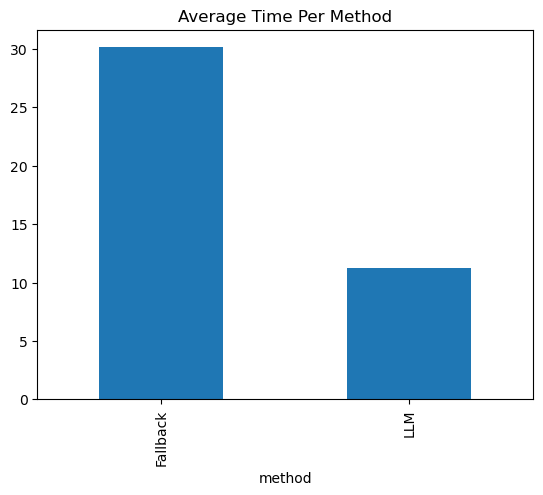

In [173]:
import pandas as pd

# Load combined logs
with open("combined_logs.json", "r") as f:
    logs = json.load(f)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(logs)

# Total records processed
total_records = len(df)

# Schema Compliance Rates
successful_records = df[df["success"] == True]
failed_records = df[df["success"] == False]
fallback_records = df[df["method"] == "Fallback"]

success_rate = len(successful_records) / total_records * 100
failure_rate = len(failed_records) / total_records * 100
fallback_rate = len(fallback_records) / total_records * 100

# LLM Success Rates
llm_records = df[df["method"] == "LLM"]
llm_success_rate = len(llm_records[llm_records["success"] == True]) / len(llm_records) * 100
llm_failure_rate = len(llm_records[llm_records["success"] == False]) / len(llm_records) * 100

# Average Transformation Time
average_time = df["time"].mean()
average_llm_time = llm_records["time"].mean()
average_fallback_time = fallback_records["time"].mean()

# Results Summary
metrics = {
    "Total Records": total_records,
    "Success Rate (%)": success_rate,
    "Failure Rate (%)": failure_rate,
    "Fallback Usage Rate (%)": fallback_rate,
    "LLM Success Rate (%)": llm_success_rate,
    "LLM Failure Rate (%)": llm_failure_rate,
    "Average Time Per Record (s)": average_time,
    "Average LLM Time (s)": average_llm_time,
    "Average Fallback Time (s)": average_fallback_time,
}

# Print Summary
print("\nMetrics Summary:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

# Save summary to a file
with open("metrics_summary.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Visualizations (Optional)
df.groupby("method")["time"].mean().plot(kind="bar", title="Average Time Per Method")


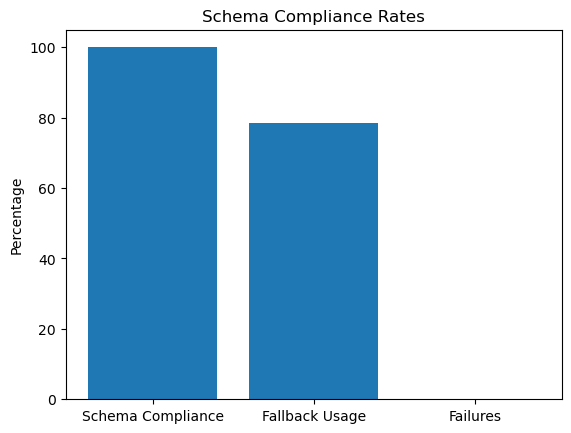

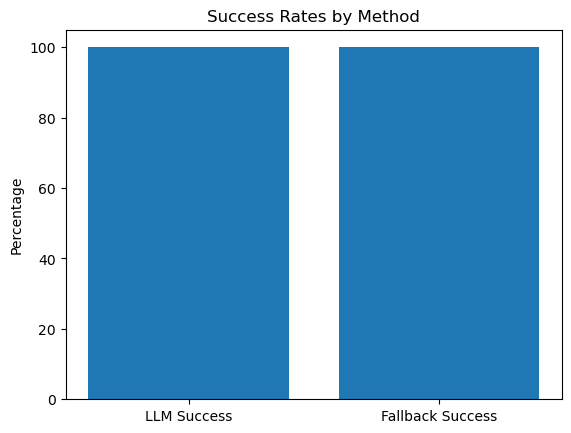

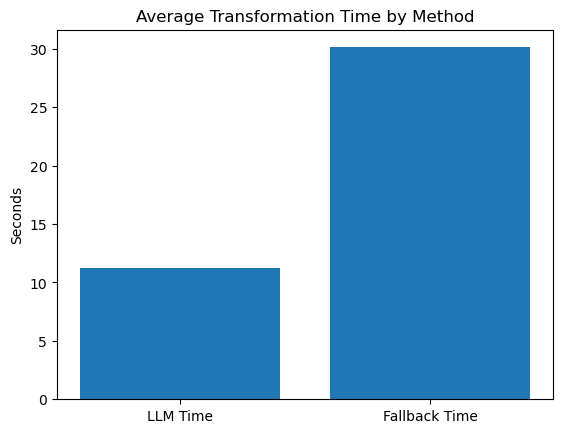


Metrics Summary:
Total Records: 14.00
LLM Success Rate (%): 100.00
Fallback Success Rate (%): 100.00
Average LLM Time (s): 11.20
Average Fallback Time (s): 30.14

Case Studies:
{
  "Successful Examples": [
    {
      "record_id": 808656,
      "method": "LLM",
      "success": true,
      "time": 11.204866647720337,
      "stage": "main_multi_model_practitioners",
      "error": null
    },
    {
      "record_id": 678669,
      "method": "LLM",
      "success": true,
      "time": 11.204866647720337,
      "stage": "main_multi_model_practitioners",
      "error": null
    }
  ],
  "Fallback Examples": [
    {
      "record_id": 386545,
      "method": "Fallback",
      "success": true,
      "time": 30.141353932293978,
      "stage": "main_multi_model_appointments",
      "error": null
    },
    {
      "record_id": 87267,
      "method": "Fallback",
      "success": true,
      "time": 30.141353932293978,
      "stage": "main_multi_model_appointments",
      "error": null
    }
  

In [174]:
import matplotlib.pyplot as plt

# Load combined logs
with open("combined_logs.json", "r") as f:
    logs = json.load(f)

# Convert to DataFrame for analysis
df = pd.DataFrame(logs)

# --- Schema Compliance Rates ---
total_records = len(df)
success_records = df[df["success"]]
failed_records = df[~df["success"]]
fallback_records = df[df["method"] == "Fallback"]

compliance_rates = {
    "LLM Schema Compliance (%)": len(success_records) / total_records * 100,
    "Fallback Usage (%)": len(fallback_records) / total_records * 100,
    "Failure Rate (%)": len(failed_records) / total_records * 100
}

# Visualize Schema Compliance
compliance_data = [
    compliance_rates["Schema Compliance (%)"],
    compliance_rates["Fallback Usage (%)"],
    compliance_rates["Failure Rate (%)"]
]
plt.figure()
plt.bar(["Schema Compliance", "Fallback Usage", "Failures"], compliance_data)
plt.title("Schema Compliance Rates")
plt.ylabel("Percentage")
plt.show()

# --- LLM Success Rates ---
llm_records = df[df["method"] == "LLM"]
llm_success_rate = len(llm_records[llm_records["success"]]) / len(llm_records) * 100
fallback_success_rate = len(fallback_records[fallback_records["success"]]) / len(fallback_records) * 100

# Visualize LLM vs. Fallback Success Rates
plt.figure()
plt.bar(["LLM Success", "Fallback Success"], [llm_success_rate, fallback_success_rate])
plt.title("Success Rates by Method")
plt.ylabel("Percentage")
plt.show()

# --- Performance Metrics ---
average_llm_time = llm_records["time"].mean()
average_fallback_time = fallback_records["time"].mean()

performance_data = [
    average_llm_time,
    average_fallback_time
]
plt.figure()
plt.bar(["LLM Time", "Fallback Time"], performance_data)
plt.title("Average Transformation Time by Method")
plt.ylabel("Seconds")
plt.show()

# --- Statistical Summaries ---
metrics_summary = {
    "Total Records": total_records,
    "LLM Success Rate (%)": llm_success_rate,
    "Fallback Success Rate (%)": fallback_success_rate,
    "Average LLM Time (s)": average_llm_time,
    "Average Fallback Time (s)": average_fallback_time
}

# Print Summary Table
print("\nMetrics Summary:")
for key, value in metrics_summary.items():
    print(f"{key}: {value:.2f}")

# Save metrics summary to JSON
with open("expanded_metrics_summary.json", "w") as f:
    json.dump(metrics_summary, f, indent=2)

# --- Case Studies/Examples ---
# Extract examples of successful, failed, and edge cases
successful_examples = success_records.head(2).to_dict(orient="records")
fallback_examples = fallback_records.head(2).to_dict(orient="records")
edge_case_examples = fallback_records[fallback_records["time"] > average_fallback_time].head(2).to_dict(orient="records")

# Save case studies to JSON
case_studies = {
    "Successful Examples": successful_examples,
    "Fallback Examples": fallback_examples,
    "Edge Case Examples": edge_case_examples
}
with open("case_studies.json", "w") as f:
    json.dump(case_studies, f, indent=2)

# Display extracted examples
print("\nCase Studies:")
print(json.dumps(case_studies, indent=2))


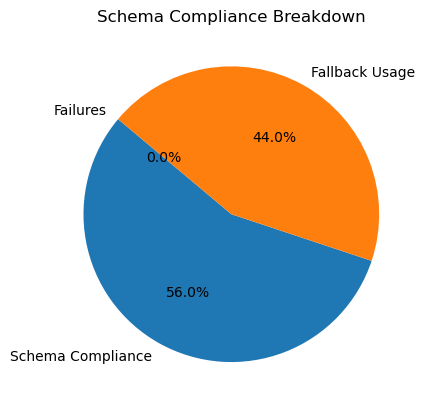

In [175]:
# Pie chart for schema compliance
compliance_labels = ["Schema Compliance", "Fallback Usage", "Failures"]
compliance_values = [
    compliance_rates["Schema Compliance (%)"],
    compliance_rates["Fallback Usage (%)"],
    compliance_rates["Failure Rate (%)"]
]

plt.figure()
plt.pie(compliance_values, labels=compliance_labels, autopct="%1.1f%%", startangle=140)
plt.title("Schema Compliance Breakdown")
plt.show()


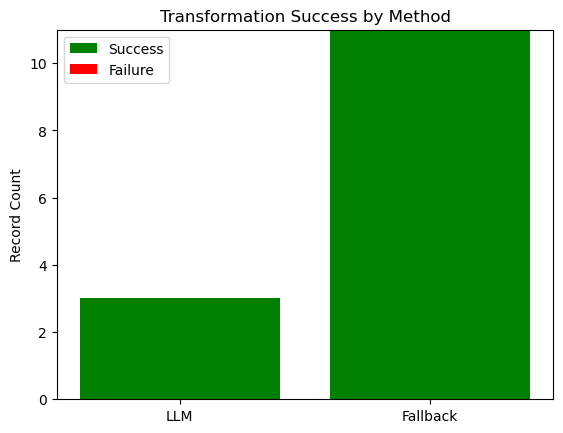

In [176]:
# Stacked bar chart for transformation success
success_counts = [
    len(llm_records[llm_records["success"]]),
    len(fallback_records[fallback_records["success"]])
]
failure_counts = [
    len(llm_records[~llm_records["success"]]),
    len(fallback_records[~fallback_records["success"]])
]

bar_width = 0.5
methods = ["LLM", "Fallback"]

plt.figure()
plt.bar(methods, success_counts, label="Success", color="green")
plt.bar(methods, failure_counts, bottom=success_counts, label="Failure", color="red")
plt.title("Transformation Success by Method")
plt.ylabel("Record Count")
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

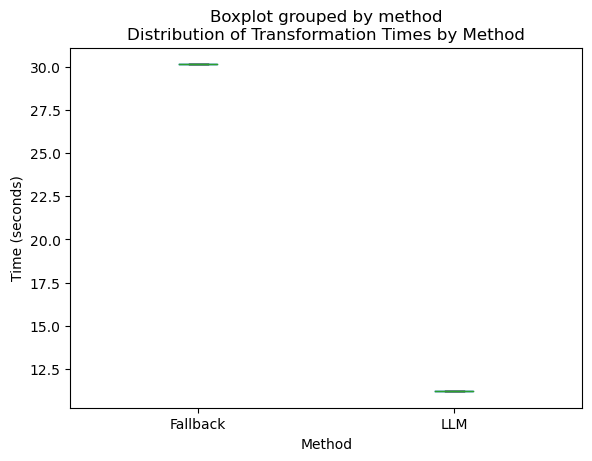

In [178]:
# Box plot for transformation times
plt.figure()
df.boxplot(column="time", by="method", grid=False)
plt.title("Distribution of Transformation Times by Method")
plt.ylabel("Time (seconds)")
plt.xlabel("Method")
plt.show()


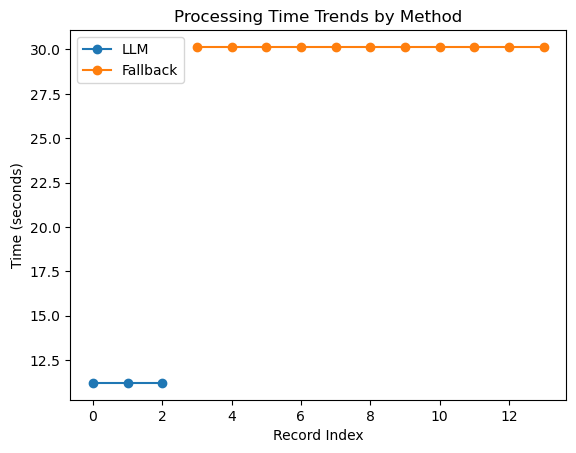

In [179]:
# Line graph for processing times
plt.figure()
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset.index, subset["time"], marker="o", label=method)

plt.title("Processing Time Trends by Method")
plt.xlabel("Record Index")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()


python(71430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


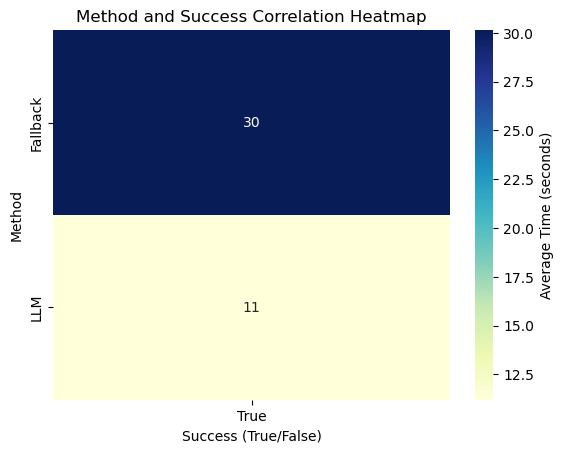

In [180]:
import seaborn as sns

# Heatmap for success and method correlation
heatmap_data = pd.pivot_table(df, values="time", index="method", columns="success", aggfunc="mean")
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={"label": "Average Time (seconds)"})
plt.title("Method and Success Correlation Heatmap")
plt.xlabel("Success (True/False)")
plt.ylabel("Method")
plt.show()


# Reference and repositories that were consulted
- LangChain Framework: LangChain provides tooling for building applications with language models. The repository demonstrates integrating prompts with LLMs and handling structured data transformations.
https://github.com/langchain-ai/langchain

- OpenAI GPT Examples: Contains examples of prompt engineering and API integration for OpenAI's GPT models, which are similar in methodology to your LLM (Ollama) use case.
https://github.com/openai/openai-cookbook

- LLM Prompt Engineering with Python: demonstrates prompt engineering techniques for various LLMs like GPT and how to adapt them to different tasks, including data transformation and formatting.
https://github.com/dair-ai/Prompt-Engineering-Guide

-   Pydantic AI Examples: This repository offers examples of building AI agents using the Pydantic AI framework, illustrating how to leverage Pydantic for structured data handling in AI applications. 
https://github.com/omkamal/pydantic_ai_examples

- Pydantic Examples: A curated collection of practical demonstrations showcasing effective utilization of Pydantic in projects, empowering developers to handle data validation and transformation efficiently. 
https://github.com/Laxmar/PydanticExamples

- Bruin Data Pipeline Tool: Bruin is a data pipeline tool that integrates data ingestion, transformation with SQL & Python, and data quality into a single framework, demonstrating robust data processing pipelines. 
https://github.com/bruin-data/bruin

- ETL Data Transformation Pipeline: This project streamlines data processing by implementing an ETL pipeline in Python, efficiently extracting data from various sources, performing transformations, and loading the results into a target destination. 
https://github.com/NikkaLuna/ETL_Data_Transformation_Pipeline

# Previous Strategies (Old and not relevant)
The section below highlights strategies that were explored before focusing on the final strategy, involves multiple trial and testing that are not included in the disseration but were performed during the execution of this project

In [2]:
from pydantic import BaseModel, field_validator
from typing import List, Optional, Dict, Any
from datetime import datetime
import json
import time
import requests

class OllamaHandler:
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        try:
            self.test_connection()
            print("Successfully connected to Ollama")
        except Exception as e:
            print(f"Warning: Could not connect to Ollama: {str(e)}")
            print("Make sure Ollama is running and Mistral is pulled")
            raise

    def test_connection(self):
        response = requests.post(self.api_url, 
                               json={"model": "mistral", 
                                    "prompt": "test", 
                                    "stream": False})
        response.raise_for_status()
        
    def generate(self, prompt: str) -> str:
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        try:
            response = requests.post(self.api_url, json=payload)
            response.raise_for_status()
            return response.json()['response']
        except Exception as e:
            print(f"Error calling Ollama: {str(e)}")
            raise

class TransformedRecord(BaseModel):
    id: int
    first_name: str 
    last_name: str
    practice_id: int
    title: Optional[str] = None
    email: Optional[str] = None
    gender: Optional[str] = None
    type: Optional[str] = None
    status: Optional[int] = None
    online: Optional[bool] = None
    employment_status: Optional[str] = None
    service_type_id: Optional[int] = None
    commission_flat_rate: Optional[int] = None
    commission_percent: Optional[int] = None
    time_slot: Optional[int] = None
    location_ids: Optional[List[int]] = None
    default_location_id: Optional[int] = None
    location_name: Optional[str] = None
    address_line_1: Optional[str] = None
    address_line_2: Optional[str] = None
    town_city: Optional[str] = None
    state_county: Optional[str] = None
    postcode_zipcode: Optional[str] = None
    country: Optional[str] = None
    phone_number: Optional[str] = None
    mobile: Optional[str] = None
    online_guid: Optional[str] = None
    skills: Optional[List[str]] = []

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr', 'Lady', 
                       'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        return clean_title if clean_title in valid_titles else None

class DataTransformer:
    def __init__(self):
        self.llm = OllamaHandler()

    def get_transformation_prompt(self, record: Dict) -> str:
        schema_example = {
            "id": "integer (keep original)",
            "first_name": "from forename",
            "last_name": "from surname",
            "practice_id": "from defaultLocationId",
            "title": "title without period",
            "email": "string",
            "gender": "string",
            "type": "string",
            "status": "integer",
            "online": "boolean",
            "employment_status": "from employmentStatus",
            "service_type_id": "from serviceTypeId",
            "commission_flat_rate": "integer",
            "commission_percent": "integer",
            "time_slot": "integer",
            "location_ids": "array of integers",
            "location_name": "string",
            "address_line_1": "parse from fullAddress",
            "address_line_2": "parse from fullAddress",
            "town_city": "parse from fullAddress",
            "state_county": "parse from fullAddress",
            "postcode_zipcode": "from postCode",
            "country": "parse from fullAddress",
            "mobile": "string",
            "online_guid": "string",
            "skills": "array"
        }

        return f"""Transform this healthcare practitioner record to exactly match the schema format.
Input Record:
{json.dumps(record, indent=2)}

Required Schema:
{json.dumps(schema_example, indent=2)}

Rules:
1. Keep all IDs and numerical values exactly as they appear
2. Parse the address from '{record.get('fullAddress', '')}' into components
3. Remove any trailing periods from title
4. Return ONLY as valid JSON matching the schema format
5. Only include fields that have values (omit null/empty)

Return the transformed data as a single JSON object."""

    def transform_record(self, record: Dict) -> Dict:
        prompt = self.get_transformation_prompt(record)
        
        try:
            llm_response = self.llm.generate(prompt)
            # Find JSON in response
            start = llm_response.find('{')
            end = llm_response.rfind('}') + 1
            if start >= 0 and end > start:
                json_str = llm_response[start:end]
                transformed = json.loads(json_str)
                
                # Ensure critical fields
                transformed['id'] = record['id']
                transformed['first_name'] = record['forename']
                transformed['last_name'] = record['surname']
                transformed['practice_id'] = record['defaultLocationId']
                
                # Validate with Pydantic
                validated = TransformedRecord(**transformed)
                return validated.model_dump(exclude_none=True)
            else:
                raise ValueError("No valid JSON found in LLM response")
                
        except Exception as e:
            print(f"LLM transformation failed: {str(e)}")
            print("Falling back to basic transformation")
            return self.transform_record_fallback(record)

    def transform_record_fallback(self, record: Dict) -> Dict:
        # Basic fallback transformation
        transformed = {
            'id': record['id'],
            'first_name': record['forename'],
            'last_name': record['surname'],
            'practice_id': record['defaultLocationId'],
            'title': record.get('title', '').rstrip('.'),
            'email': record.get('email'),
            'gender': record.get('gender'),
            'type': record.get('type'),
            'status': record.get('status'),
            'online': record.get('online'),
            'employment_status': record.get('employmentStatus'),
            'service_type_id': record.get('serviceTypeId'),
            'location_ids': record.get('locationIds'),
            'location_name': record.get('locationName'),
            'mobile': record.get('mobile'),
            'online_guid': record.get('onlineGuid')
        }
        
        # Basic address parsing
        if record.get('fullAddress'):
            parts = [p.strip() for p in record['fullAddress'].split(',')]
            if len(parts) >= 1: transformed['address_line_1'] = parts[0]
            if len(parts) >= 2: transformed['address_line_2'] = parts[1]
            if len(parts) >= 3: transformed['town_city'] = parts[2]
            if len(parts) >= 4: transformed['state_county'] = parts[3]
            if len(parts) >= 5: transformed['country'] = parts[-1]
        if record.get('postCode'):
            transformed['postcode_zipcode'] = record['postCode']
            
        return transformed

    def transform_data(self, input_records: List[Dict]) -> List[Dict]:
        transformed_records = []
        for i, record in enumerate(input_records, 1):
            print(f"Processing record {i}/{len(input_records)}")
            try:
                transformed = self.transform_record(record)
                transformed_records.append(transformed)
                print(f"Successfully transformed record {i}")
            except Exception as e:
                print(f"Error processing record {i}: {str(e)}")
                continue
        return transformed_records

def main():
    with open('clientdata2.json', 'r') as f:
        input_data = json.load(f)
    
    start_time = time.time()
    transformer = DataTransformer()
    transformed_data = transformer.transform_data(input_data['results'])
    print(f"\nProcessing time: {time.time() - start_time:.2f} seconds")
    
    with open('transformed_output.json', 'w') as f:
        json.dump(transformed_data, f, indent=2)
        
    print("\nSample transformed record:")
    print(json.dumps(transformed_data, indent=2))
    return transformed_data

if __name__ == "__main__":
    transformed_data = main()

Successfully connected to Ollama
Processing record 1/5
Successfully transformed record 1
Processing record 2/5
Successfully transformed record 2
Processing record 3/5
Successfully transformed record 3
Processing record 4/5
Successfully transformed record 4
Processing record 5/5
Successfully transformed record 5

Processing time: 158.16 seconds

Sample transformed record:
[
  {
    "id": 640152,
    "first_name": "Matilda",
    "last_name": "Wilson",
    "practice_id": 490058,
    "title": "Dr",
    "email": "fred.saunders@example.org",
    "gender": "Female",
    "type": "Owner",
    "status": 1,
    "online": true,
    "employment_status": "Owner",
    "service_type_id": 1,
    "commission_flat_rate": 0,
    "commission_percent": 0,
    "time_slot": 0,
    "location_ids": [
      490058
    ],
    "location_name": "Hill Ltd",
    "address_line_1": "432 Tara Locks",
    "address_line_2": "",
    "town_city": "East Jordan, Surrey",
    "state_county": "Surrey",
    "postcode_zipcode": "

In [29]:
# JUPYTER NOTEBOOK CELL 1
import json
import logging
import time
from datetime import datetime
from typing import List, Optional, Dict, Any

import requests
from pydantic import BaseModel, field_validator

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [31]:

class TransformedRecord(BaseModel):
    """
    Core schema for transformed healthcare practitioner records.
    Reflects the complex relationships in healthcare data.
    """
    id: int
    first_name: str
    last_name: str
    practice_id: int

    # Optional fields
    title: Optional[str] = None
    email: Optional[str] = None
    gender: Optional[str] = None
    type: Optional[str] = None
    status: Optional[int] = None
    online: Optional[bool] = None
    employment_status: Optional[str] = None
    service_type_id: Optional[int] = None
    commission_flat_rate: Optional[int] = None
    commission_percent: Optional[int] = None
    time_slot: Optional[int] = None
    location_ids: Optional[List[int]] = None
    default_location_id: Optional[int] = None
    location_name: Optional[str] = None
    address_line_1: Optional[str] = None
    address_line_2: Optional[str] = None
    town_city: Optional[str] = None
    state_county: Optional[str] = None
    postcode_zipcode: Optional[str] = None
    country: Optional[str] = None
    phone_number: Optional[str] = None
    mobile: Optional[str] = None
    online_guid: Optional[str] = None
    skills: Optional[List[str]] = []

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        """Validate and standardize professional titles."""
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr',
                        'Lady', 'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')  # remove trailing period
        return clean_title if clean_title in valid_titles else None


In [33]:
# JUPYTER NOTEBOOK CELL 3

class OllamaHandler:
    """
    Local LLM handler ensuring data privacy and GDPR compliance 
    by processing everything on localhost.
    """
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        
        # Test connection at initialization
        try:
            self.test_connection()
            logging.info("Successfully connected to Ollama (Mistral).")
        except Exception as e:
            logging.warning(f"Could not connect to Ollama: {str(e)}. "
                            "Ensure Mistral is running locally.")
            raise

    def test_connection(self):
        """Checks if the local LLM endpoint is available."""
        response = requests.post(
            self.api_url, 
            json={"model": "mistral", "prompt": "test", "stream": False}
        )
        response.raise_for_status()

    def generate(self, prompt: str) -> str:
        """
        Generate transformations while maintaining data locality.
        Returns the text response from Mistral/Ollama.
        """
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        try:
            response = requests.post(self.api_url, json=payload)
            response.raise_for_status()
            return response.json()['response']
        except Exception as e:
            logging.error(f"Error calling Mistral: {str(e)}")
            raise


In [35]:
# JUPYTER NOTEBOOK CELL 4

class PromptManager:
    """
    Manages prompt engineering aspects, including 
    example-based prompting, strict JSON requests, etc.
    """
    def __init__(self):
        pass  # Could load templates or config from files, if desired.

    def generate_transformation_prompt(self, record: Dict) -> str:
        """
        Construct a transformation prompt with rules and instructions,
        referencing your schema requirements.
        """
        schema_example = {
            "id": "integer (keep original)",
            "first_name": "from forename",
            "last_name": "from surname",
            "practice_id": "from defaultLocationId",
            "title": "title without period",
            "email": "string",
            "gender": "string",
            "type": "string",
            "status": "integer",
            "online": "boolean",
            "employment_status": "from employmentStatus",
            "service_type_id": "from serviceTypeId",
            "commission_flat_rate": "integer",
            "commission_percent": "integer",
            "time_slot": "integer",
            "location_ids": "array of integers",
            "location_name": "string",
            "address_line_1": "parse from fullAddress",
            "address_line_2": "parse from fullAddress",
            "town_city": "parse from fullAddress",
            "state_county": "parse from fullAddress",
            "postcode_zipcode": "from postCode",
            "country": "parse from fullAddress",
            "mobile": "string",
            "online_guid": "string",
            "skills": "array"
        }

        # Optionally, demonstrate a small "BEFORE -> AFTER" example to guide the model
        example_before = {
            "id": 101,
            "forename": "Alice",
            "surname": "Smith",
            "defaultLocationId": 999,
            "title": "Dr.",
            "fullAddress": "123 Main St, Some City, Some State, Some Country",
            "postCode": "12345"
        }
        example_after = {
            "id": 101,
            "first_name": "Alice",
            "last_name": "Smith",
            "practice_id": 999,
            "title": "Dr",
            "address_line_1": "123 Main St",
            "town_city": "Some City",
            "state_county": "Some State",
            "country": "Some Country",
            "postcode_zipcode": "12345"
        }

        # Building a prompt with example references
        return f"""
You are a JSON transformation engine.
Below is an example transformation:

BEFORE:
{json.dumps(example_before, indent=2)}

AFTER:
{json.dumps(example_after, indent=2)}

Now transform this new record to the same schema.

Input Record:
{json.dumps(record, indent=2)}

Required Schema:
{json.dumps(schema_example, indent=2)}

Rules:
1. Keep all IDs and numerical values exactly as they appear.
2. Parse address from 'fullAddress' into address_line_1, address_line_2, town_city, state_county, and country.
3. Remove trailing periods from title.
4. Return ONLY valid JSON matching the schema format.
5. Omit null or empty fields.

Reply with valid JSON only, no extra text.
        """.strip()


In [36]:
# JUPYTER NOTEBOOK CELL 5

class TransformationAuditor:
    """
    Audit trail management for regulatory compliance.
    Stores or logs each transformation event.
    """
    def __init__(self):
        self.audit_records = []

    def log_transformation(self, original: Dict, transformed: Dict, metadata: Dict) -> None:
        """
        Log transformation details for compliance and auditing.
        """
        audit_record = {
            'timestamp': datetime.now().isoformat(),
            'original_data': original,
            'transformed_data': transformed,
            'transformation_metadata': metadata
        }
        self.audit_records.append(audit_record)
        # You could also write to a database, file, or external auditing system
        logging.info("Transformation audited successfully.")


In [37]:
# JUPYTER NOTEBOOK CELL 6

class PerformanceMonitor:
    """
    Monitors performance metrics such as transformation time,
    validation time, etc.
    """
    def __init__(self):
        self.metrics = {
            'transformation_times': [],
            'validation_times': [],
            'error_counts': 0
        }

    def record_transformation_time(self, duration: float) -> None:
        self.metrics['transformation_times'].append(duration)

    def record_validation_time(self, duration: float) -> None:
        self.metrics['validation_times'].append(duration)

    def record_error(self) -> None:
        self.metrics['error_counts'] += 1

    def get_summary(self) -> Dict[str, Any]:
        """
        Return summary of all collected metrics.
        """
        total_transforms = len(self.metrics['transformation_times'])
        avg_transform_time = (sum(self.metrics['transformation_times']) / total_transforms) if total_transforms else 0

        total_validations = len(self.metrics['validation_times'])
        avg_validation_time = (sum(self.metrics['validation_times']) / total_validations) if total_validations else 0

        return {
            'total_transformations': total_transforms,
            'avg_transformation_time': avg_transform_time,
            'avg_validation_time': avg_validation_time,
            'error_counts': self.metrics['error_counts']
        }


In [39]:
# JUPYTER NOTEBOOK CELL 8

class DataTransformer:
    """
    Orchestrates the entire transformation process: 
    1) Build LLM prompts
    2) Call the LLM (Mistral via OllamaHandler)
    3) Validate results (Pydantic)
    4) Fallback if needed
    5) Audit transformations
    6) Check compliance
    7) Monitor performance
    """
    def __init__(self, auditor: TransformationAuditor, 
                 performance_monitor: PerformanceMonitor,
                 compliance_manager: ComplianceManager):
        self.llm = OllamaHandler()
        self.prompt_manager = PromptManager()
        self.auditor = auditor
        self.performance_monitor = performance_monitor
        self.compliance_manager = compliance_manager

    def transform_record(self, record: Dict) -> Dict:
        """
        Transforms a single record using an LLM prompt.
        Includes fallback logic if LLM fails or returns invalid data.
        """
        # Check compliance first
        if not self.compliance_manager.ensure_compliance(record):
            logging.warning("Record did not pass compliance check. Skipping.")
            return {}

        # Generate prompt
        prompt = self.prompt_manager.generate_transformation_prompt(record)

        # Time the transformation
        start_time = time.time()

        try:
            llm_response = self.llm.generate(prompt)
            # Find JSON in response
            start_idx = llm_response.find('{')
            end_idx = llm_response.rfind('}') + 1

            if start_idx >= 0 and end_idx > start_idx:
                json_str = llm_response[start_idx:end_idx]
                transformed = json.loads(json_str)

                # Overwrite certain critical fields (per your original code):
                transformed['id'] = record.get('id')
                transformed['first_name'] = record.get('forename')
                transformed['last_name'] = record.get('surname')
                transformed['practice_id'] = record.get('defaultLocationId')

                # Validate with Pydantic
                # Time the validation separately, for clarity
                validation_start = time.time()
                validated = TransformedRecord(**transformed)
                validation_end = time.time()
                
                self.performance_monitor.record_validation_time(validation_end - validation_start)

                # Done. Return the valid data, omitting null fields
                final_data = validated.model_dump(exclude_none=True)

                # Record performance
                end_time = time.time()
                self.performance_monitor.record_transformation_time(end_time - start_time)

                # Audit
                meta = {
                    "method": "LLM",
                    "success": True
                }
                self.auditor.log_transformation(record, final_data, meta)

                return final_data
            else:
                raise ValueError("No valid JSON found in LLM response")

        except Exception as e:
            logging.error(f"LLM transformation failed: {str(e)}. Using fallback.")
            self.performance_monitor.record_error()
            # Fallback approach
            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)

            return self.transform_record_fallback(record)

    def transform_record_fallback(self, record: Dict) -> Dict:
        """
        Basic fallback transformation if LLM fails.
        Reflects Section 3.6.1 on fallback / limitations handling.
        """
        transformed = {
            'id': record.get('id'),
            'first_name': record.get('forename'),
            'last_name': record.get('surname'),
            'practice_id': record.get('defaultLocationId'),
            'title': record.get('title', '').rstrip('.'),
            'email': record.get('email'),
            'gender': record.get('gender'),
            'type': record.get('type'),
            'status': record.get('status'),
            'online': record.get('online'),
            'employment_status': record.get('employmentStatus'),
            'service_type_id': record.get('serviceTypeId'),
            'location_ids': record.get('locationIds'),
            'location_name': record.get('locationName'),
            'mobile': record.get('mobile'),
            'online_guid': record.get('onlineGuid')
        }

        # Basic address parsing
        if record.get('fullAddress'):
            parts = [p.strip() for p in record['fullAddress'].split(',')]
            if len(parts) >= 1: transformed['address_line_1'] = parts[0]
            if len(parts) >= 2: transformed['address_line_2'] = parts[1]
            if len(parts) >= 3: transformed['town_city'] = parts[2]
            if len(parts) >= 4: transformed['state_county'] = parts[3]
            if len(parts) >= 5: transformed['country'] = parts[-1]

        if record.get('postCode'):
            transformed['postcode_zipcode'] = record['postCode']

        # Validate with Pydantic again if you wish:
        try:
            validated = TransformedRecord(**transformed)
            final_data = validated.model_dump(exclude_none=True)
        except Exception as e:
            logging.error(f"Fallback validation failed: {str(e)}.")
            final_data = transformed  # or handle differently

        # Log the fallback in the auditor
        meta = {
            "method": "Fallback",
            "success": True
        }
        self.auditor.log_transformation(record, final_data, meta)

        return final_data

    def transform_data(self, input_records: List[Dict]) -> List[Dict]:
        """
        Batch transformation: processes multiple records, logs times, errors, etc.
        """
        transformed_records = []
        for i, record in enumerate(input_records, start=1):
            logging.info(f"Processing record {i}/{len(input_records)}")
            result = self.transform_record(record)
            transformed_records.append(result)
        return transformed_records


In [41]:
import requests
from pydantic import BaseModel, field_validator
import logging
import json
import time

# Configure basic logging for easier debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def main():
    # Load JSON input data
    with open('CustomerAppointmentResponsecopy.json', 'r') as f:
        input_data = json.load(f)

    # Initialize our supporting classes
    auditor = TransformationAuditor()
    perf_monitor = PerformanceMonitor()
    compliance_manager = ComplianceManager()

    # Create the DataTransformer
    transformer = DataTransformer(
        auditor=auditor, 
        performance_monitor=perf_monitor,
        compliance_manager=compliance_manager
    )

    # Extract records 11 through 20
    selected_records = input_data['results'][10:20]

    # Time the processing of selected records
    overall_start = time.time()

    transformed_data = transformer.transform_data(selected_records)

    overall_end = time.time()
    logging.info(f"Total processing time for selected records: {overall_end - overall_start:.2f} seconds")

    # Print transformed data to console
    logging.info("Full Transformed Data:")
    print(json.dumps(transformed_data, indent=2))

    # Print sample
    logging.info("Sample transformed record(s):")
    print(json.dumps(transformed_data[:3], indent=2))  # Show first 3 records as a preview

    # Show performance summary
    summary = perf_monitor.get_summary()
    logging.info(f"Performance Summary: {summary}")

    # Show how many transformations were audited
    logging.info(f"Total audited transformations: {len(auditor.audit_records)}")

    return transformed_data

# If running as a script inside Jupyter, you could just call main() here:
result_data = main()


2025-01-01 13:50:48,921 - INFO - Successfully connected to Ollama (Mistral).
2025-01-01 13:50:48,925 - INFO - Processing record 1/10
2025-01-01 13:51:14,954 - ERROR - LLM transformation failed: 7 validation errors for TransformedRecord
first_name
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
last_name
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
practice_id
  Input should be a valid integer [type=int_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/int_type
status
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='integer', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/int_parsing
se

[
  {
    "id": 867055,
    "first_name": null,
    "last_name": null,
    "practice_id": null,
    "title": "Prof",
    "email": null,
    "gender": null,
    "type": "A",
    "status": 2,
    "online": null,
    "employment_status": null,
    "service_type_id": 413974,
    "location_ids": null,
    "location_name": null,
    "mobile": null,
    "online_guid": null
  },
  {
    "id": 593586,
    "first_name": null,
    "last_name": null,
    "practice_id": null,
    "title": "Mr",
    "email": null,
    "gender": null,
    "type": "A",
    "status": 2,
    "online": null,
    "employment_status": null,
    "service_type_id": 283474,
    "location_ids": null,
    "location_name": null,
    "mobile": null,
    "online_guid": null
  },
  {
    "id": 74359,
    "first_name": null,
    "last_name": null,
    "practice_id": null,
    "title": "Mr",
    "email": null,
    "gender": null,
    "type": "A",
    "status": 2,
    "online": null,
    "employment_status": null,
    "service_type_id

In [3]:
from pydantic import BaseModel, field_validator
from typing import List, Optional, Dict, Any
from datetime import datetime
import json
import time
import requests

class OllamaHandler:
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        try:
            self.test_connection()
            print("Successfully connected to Ollama")
        except Exception as e:
            print(f"Warning: Could not connect to Ollama: {str(e)}")
            print("Make sure Ollama is running and Mistral is pulled")
            raise

    def test_connection(self):
        response = requests.post(self.api_url, 
                               json={"model": "mistral", 
                                    "prompt": "test", 
                                    "stream": False})
        response.raise_for_status()
        
    def generate(self, prompt: str) -> str:
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        try:
            response = requests.post(self.api_url, json=payload)
            response.raise_for_status()
            return response.json()['response']
        except Exception as e:
            print(f"Error calling Ollama: {str(e)}")
            raise

class TransformedRecord(BaseModel):
    id: int
    first_name: str 
    last_name: str
    practice_id: int
    title: Optional[str] = None
    email: Optional[str] = None
    gender: Optional[str] = None
    type: Optional[str] = None
    status: Optional[int] = None
    online: Optional[bool] = None
    employment_status: Optional[str] = None
    service_type_id: Optional[int] = None
    commission_flat_rate: Optional[int] = None
    commission_percent: Optional[int] = None
    time_slot: Optional[int] = None
    location_ids: Optional[List[int]] = None
    default_location_id: Optional[int] = None
    location_name: Optional[str] = None
    address_line_1: Optional[str] = None
    address_line_2: Optional[str] = None
    town_city: Optional[str] = None
    state_county: Optional[str] = None
    postcode_zipcode: Optional[str] = None
    country: Optional[str] = None
    phone_number: Optional[str] = None
    mobile: Optional[str] = None
    online_guid: Optional[str] = None
    skills: Optional[List[str]] = []

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr', 'Lady', 
                       'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        return clean_title if clean_title in valid_titles else None

class DataTransformer:
    def __init__(self):
        self.llm = OllamaHandler()

    def get_transformation_prompt(self, record: Dict) -> str:
        schema_example = {
            "id": "integer (keep original)",
            "first_name": "from forename",
            "last_name": "from surname",
            "practice_id": "from defaultLocationId",
            "title": "title without period",
            "email": "string",
            "gender": "string",
            "type": "string",
            "status": "integer",
            "online": "boolean",
            "employment_status": "from employmentStatus",
            "service_type_id": "from serviceTypeId",
            "commission_flat_rate": "integer",
            "commission_percent": "integer",
            "time_slot": "integer",
            "location_ids": "array of integers",
            "location_name": "string",
            "address_line_1": "parse from fullAddress",
            "address_line_2": "parse from fullAddress",
            "town_city": "parse from fullAddress",
            "state_county": "parse from fullAddress",
            "postcode_zipcode": "from postCode",
            "country": "parse from fullAddress",
            "mobile": "string",
            "online_guid": "string",
            "skills": "array"
        }

        return f"""Transform this healthcare practitioner record to exactly match the schema format.
Input Record:
{json.dumps(record, indent=2)}

Required Schema:
{json.dumps(schema_example, indent=2)}

Rules:
1. Keep all IDs and numerical values exactly as they appear
2. Parse the address from '{record.get('fullAddress', '')}' into components
3. Remove any trailing periods from title
4. Return ONLY as valid JSON matching the schema format
5. Only include fields that have values (omit null/empty)

Return the transformed data as a single JSON object."""

    def transform_record(self, record: Dict) -> Dict:
        prompt = self.get_transformation_prompt(record)
        
        try:
            llm_response = self.llm.generate(prompt)
            # Find JSON in response
            start = llm_response.find('{')
            end = llm_response.rfind('}') + 1
            if start >= 0 and end > start:
                json_str = llm_response[start:end]
                transformed = json.loads(json_str)
                
                # Ensure critical fields
                transformed['id'] = record['id']
                transformed['first_name'] = record['forename']
                transformed['last_name'] = record['surname']
                transformed['practice_id'] = record['defaultLocationId']
                
                # Validate with Pydantic
                validated = TransformedRecord(**transformed)
                return validated.model_dump(exclude_none=True)
            else:
                raise ValueError("No valid JSON found in LLM response")
                
        except Exception as e:
            print(f"LLM transformation failed: {str(e)}")
            print("Falling back to basic transformation")
            return self.transform_record_fallback(record)

    def transform_record_fallback(self, record: Dict) -> Dict:
        # Basic fallback transformation
        transformed = {
            'id': record['id'],
            'first_name': record['forename'],
            'last_name': record['surname'],
            'practice_id': record['defaultLocationId'],
            'title': record.get('title', '').rstrip('.'),
            'email': record.get('email'),
            'gender': record.get('gender'),
            'type': record.get('type'),
            'status': record.get('status'),
            'online': record.get('online'),
            'employment_status': record.get('employmentStatus'),
            'service_type_id': record.get('serviceTypeId'),
            'location_ids': record.get('locationIds'),
            'location_name': record.get('locationName'),
            'mobile': record.get('mobile'),
            'online_guid': record.get('onlineGuid')
        }
        
        # Basic address parsing
        if record.get('fullAddress'):
            parts = [p.strip() for p in record['fullAddress'].split(',')]
            if len(parts) >= 1: transformed['address_line_1'] = parts[0]
            if len(parts) >= 2: transformed['address_line_2'] = parts[1]
            if len(parts) >= 3: transformed['town_city'] = parts[2]
            if len(parts) >= 4: transformed['state_county'] = parts[3]
            if len(parts) >= 5: transformed['country'] = parts[-1]
        if record.get('postCode'):
            transformed['postcode_zipcode'] = record['postCode']
            
        return transformed

    def transform_data(self, input_records: List[Dict]) -> List[Dict]:
        transformed_records = []
        for i, record in enumerate(input_records, 1):
            print(f"Processing record {i}/{len(input_records)}")
            try:
                transformed = self.transform_record(record)
                transformed_records.append(transformed)
                print(f"Successfully transformed record {i}")
            except Exception as e:
                print(f"Error processing record {i}: {str(e)}")
                continue
        return transformed_records

def main():
    with open('client_data.json', 'r') as f:
        input_data = json.load(f)
    
    start_time = time.time()
    transformer = DataTransformer()
    transformed_data = transformer.transform_data(input_data['results'])
    print(f"\nProcessing time: {time.time() - start_time:.2f} seconds")
    
    with open('2transformed_output.json', 'w') as f:
        json.dump(transformed_data, f, indent=2)
        
    print("\nSample transformed record:")
    print(json.dumps(transformed_data, indent=2))
    return transformed_data

if __name__ == "__main__":
    transformed_data = main()

Successfully connected to Ollama
Processing record 1/3
Successfully transformed record 1
Processing record 2/3
LLM transformation failed: Expecting property name enclosed in double quotes: line 8 column 24 (char 169)
Falling back to basic transformation
Successfully transformed record 2
Processing record 3/3
Successfully transformed record 3

Processing time: 92.84 seconds

Sample transformed record:
[
  {
    "id": 808656,
    "first_name": "Mandy",
    "last_name": "Thompson",
    "practice_id": 932896,
    "title": "Ms",
    "email": "louis.mitchell@example.org",
    "gender": "Female",
    "type": "Owner",
    "status": 1,
    "online": true,
    "employment_status": "Owner",
    "service_type_id": 1,
    "commission_flat_rate": 0,
    "commission_percent": 0,
    "time_slot": 0,
    "location_ids": [
      932896
    ],
    "location_name": "Marshall Ltd",
    "address_line_1": "Flat 49\nStacey Junction",
    "town_city": "South Peter, Cambridgeshire",
    "state_county": "NG24 2P

In [17]:
from pydantic import BaseModel, field_validator
from typing import List, Optional, Dict, Any
from datetime import datetime
import json
import time
import requests

class OllamaHandler:
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        try:
            self.test_connection()
            print("Successfully connected to Ollama")
        except Exception as e:
            print(f"Warning: Could not connect to Ollama: {str(e)}")
            print("Make sure Ollama is running and Mistral is pulled")
            raise

    def test_connection(self):
        response = requests.post(
            self.api_url, 
            json={"model": "mistral", "prompt": "test", "stream": False}
        )
        response.raise_for_status()
        
    def generate(self, prompt: str) -> str:
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        try:
            response = requests.post(self.api_url, json=payload)
            response.raise_for_status()
            return response.json()['response']
        except Exception as e:
            print(f"Error calling Ollama: {str(e)}")
            raise

class TransformedRecord(BaseModel):
    id: int
    first_name: str
    last_name: str
    practice_id: int
    title: Optional[str] = None
    email: Optional[str] = None
    gender: Optional[str] = None
    type: Optional[str] = None
    status: Optional[int] = None
    online: Optional[bool] = None
    employment_status: Optional[str] = None
    service_type_id: Optional[int] = None
    commission_flat_rate: Optional[int] = None
    commission_percent: Optional[int] = None
    time_slot: Optional[int] = None
    location_ids: Optional[List[int]] = None
    default_location_id: Optional[int] = None
    location_name: Optional[str] = None
    address_line_1: Optional[str] = None
    address_line_2: Optional[str] = None
    town_city: Optional[str] = None
    state_county: Optional[str] = None
    postcode_zipcode: Optional[str] = None
    country: Optional[str] = None
    phone_number: Optional[str] = None
    mobile: Optional[str] = None
    online_guid: Optional[str] = None
    skills: Optional[List[str]] = []

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr', 'Lady', 
                        'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        return clean_title if clean_title in valid_titles else None

class DataTransformer:
    def __init__(self):
        self.llm = OllamaHandler()
        self.transformed_model = TransformedRecord

    def get_transformation_prompt(self, record: Dict) -> str:
        schema_example = {
            "id": 123456,
            "first_name": "John",
            "last_name": "Doe",
            "practice_id": 654321,
            "title": "Dr",
            "email": "john.doe@example.com",
            "gender": "Male",
            "type": "Owner",
            "status": 1,
            "online": True,
            "employment_status": "Owner",
            "service_type_id": 1,
            "location_ids": [123456],
            "location_name": "Example Ltd",
            "address_line_1": "123 Main St",
            "address_line_2": "Suite 101",
            "town_city": "Sample City",
            "state_county": "Example State",
            "postcode_zipcode": "AB12 3CD",
            "country": "CountryName",
            "mobile": "07123456789",
            "online_guid": "unique-guid-1234",
            "skills": ["skill1", "skill2"]
        }

        return f"""Transform this healthcare practitioner record to match the schema.
Input Record:
{json.dumps(record, indent=2)}

Required Schema:
{json.dumps(schema_example, indent=2)}

Rules:
1. Use double quotes for JSON keys and values.
2. Strictly follow the schema format provided.
3. Parse addresses into components as shown in the example.
4. Only include non-null and non-empty fields in the output.
5. Ensure data types strictly adhere to the schema.
6. Escape special characters in strings.
7. Return valid JSON with no errors.

Example Output:
{json.dumps(schema_example, indent=2)}

Return the transformed data as valid JSON below:
"""

    def transform_record(self, record: Dict) -> Dict:
        prompt = self.get_transformation_prompt(record)
        try:
            llm_response = self.llm.generate(prompt)
            start = llm_response.find('{')
            end = llm_response.rfind('}') + 1

            if start >= 0 and end > start:
                json_str = llm_response[start:end]

                # Ensure escaped characters are handled
                json_str = json_str.replace('\\', '\\\\').replace('\"', '\\\"')

                transformed = json.loads(json_str)

                # Validate with Pydantic
                validated = self.transformed_model(**transformed)
                return validated.model_dump(exclude_none=True)
            else:
                raise ValueError("No valid JSON found in LLM response")
        except Exception as e:
            print(f"LLM transformation failed: {str(e)}")
            print("Falling back to basic transformation")
            return self.transform_record_fallback(record)

    def transform_record_fallback(self, record: Dict) -> Dict:
        transformed = {
            'id': record['id'],
            'first_name': record['forename'],
            'last_name': record['surname'],
            'practice_id': record['defaultLocationId'],
            'title': record.get('title', '').rstrip('.'),
            'email': record.get('email'),
            'gender': record.get('gender'),
            'type': record.get('type'),
            'status': record.get('status'),
            'online': record.get('online'),
            'employment_status': record.get('employmentStatus'),
            'service_type_id': record.get('serviceTypeId'),
            'location_ids': record.get('locationIds'),
            'location_name': record.get('locationName'),
            'mobile': record.get('mobile'),
            'online_guid': record.get('onlineGuid')
        }

        if record.get('fullAddress'):
            parts = [p.strip() for p in record['fullAddress'].split(',')]
            if len(parts) >= 1: transformed['address_line_1'] = parts[0]
            if len(parts) >= 2: transformed['address_line_2'] = parts[1]
            if len(parts) >= 3: transformed['town_city'] = parts[2]
            if len(parts) >= 4: transformed['state_county'] = parts[3]
            if len(parts) >= 5: transformed['country'] = parts[-1]
        if record.get('postCode'):
            transformed['postcode_zipcode'] = record['postCode']

        # Validate fallback transformation
        try:
            validated = self.transformed_model(**transformed)
            return validated.model_dump(exclude_none=True)
        except Exception as e:
            print(f"Fallback validation failed: {str(e)}")
            return transformed

    def transform_data(self, input_records: List[Dict]) -> List[Dict]:
        transformed_records = []
        for i, record in enumerate(input_records, 1):
            print(f"Processing record {i}/{len(input_records)}")
            try:
                transformed = self.transform_record(record)
                transformed_records.append(transformed)
                print(f"Successfully transformed record {i}")
            except Exception as e:
                print(f"Error processing record {i}: {str(e)}")
                continue
        return transformed_records

def main():
    with open('clientdata2.json', 'r') as f:
        input_data = json.load(f)
    
    start_time = time.time()
    transformer = DataTransformer()
    transformed_data = transformer.transform_data(input_data['results'])
    print(f"\nProcessing time: {time.time() - start_time:.2f} seconds")
    
    with open('2transformed_output.json', 'w') as f:
        json.dump(transformed_data, f, indent=2)
        
    print("\nSample transformed record:")
    print(json.dumps(transformed_data, indent=2))
    return transformed_data

if __name__ == "__main__":
    transformed_data = main()


Successfully connected to Ollama
Processing record 1/5
LLM transformation failed: Expecting property name enclosed in double quotes: line 2 column 7 (char 8)
Falling back to basic transformation
Successfully transformed record 1
Processing record 2/5
LLM transformation failed: Expecting property name enclosed in double quotes: line 2 column 7 (char 8)
Falling back to basic transformation
Successfully transformed record 2
Processing record 3/5
LLM transformation failed: Expecting property name enclosed in double quotes: line 2 column 7 (char 8)
Falling back to basic transformation
Successfully transformed record 3
Processing record 4/5
LLM transformation failed: Expecting property name enclosed in double quotes: line 2 column 7 (char 8)
Falling back to basic transformation
Successfully transformed record 4
Processing record 5/5
LLM transformation failed: Expecting property name enclosed in double quotes: line 2 column 7 (char 8)
Falling back to basic transformation
Successfully transfor

In [45]:
############################################################
# CHUNK 1: Imports & Logging
############################################################

import json
import time
import logging
import requests
from datetime import datetime
from typing import List, Optional, Dict, Any, Union

# Pydantic
from pydantic import BaseModel, field_validator, ValidationError

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


############################################################
# CHUNK 2: Auditor, Performance, Compliance Classes
############################################################

class TransformationAuditor:
    """
    Audit trail for logging transformations (for compliance or debugging).
    """
    def __init__(self):
        self.audit_records = []

    def log_transformation(self, original: Dict, transformed: Dict, metadata: Dict) -> None:
        audit_record = {
            'timestamp': datetime.now().isoformat(),
            'original_data': original,
            'transformed_data': transformed,
            'transformation_metadata': metadata
        }
        self.audit_records.append(audit_record)
        logging.info("Transformation audited successfully.")


class PerformanceMonitor:
    """
    Tracks transformation metrics like time and error counts.
    """
    def __init__(self):
        self.metrics = {
            'transformation_times': [],
            'validation_times': [],
            'error_counts': 0
        }

    def record_transformation_time(self, duration: float):
        self.metrics['transformation_times'].append(duration)

    def record_validation_time(self, duration: float):
        self.metrics['validation_times'].append(duration)

    def record_error(self):
        self.metrics['error_counts'] += 1

    def get_summary(self) -> Dict[str, Any]:
        total_xforms = len(self.metrics['transformation_times'])
        avg_xform_time = (sum(self.metrics['transformation_times']) / total_xforms) if total_xforms else 0

        total_validations = len(self.metrics['validation_times'])
        avg_validation_time = (sum(self.metrics['validation_times']) / total_validations) if total_validations else 0

        return {
            'total_transformations': total_xforms,
            'avg_transformation_time': avg_xform_time,
            'avg_validation_time': avg_validation_time,
            'error_counts': self.metrics['error_counts']
        }


class ComplianceManager:
    """
    Placeholder for compliance checks, e.g., GDPR logic.
    """
    def ensure_compliance(self, record: Dict) -> bool:
        # Return True if record is okay to process, otherwise False.
        return True  # Simplified for demonstration.


############################################################
# CHUNK 3: OllamaHandler (Local LLM Integration)
############################################################

class OllamaHandler:
    """
    Connects to a locally running Ollama (Mistral) server on http://localhost:11434
    """
    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.api_url = "http://localhost:11434/api/generate"
        try:
            self.test_connection()
            logging.info("Successfully connected to Ollama (Mistral).")
        except Exception as e:
            logging.warning(f"Could not connect to Ollama: {str(e)}. Ensure Mistral is running locally.")
            raise

    def test_connection(self):
        response = requests.post(
            self.api_url, 
            json={"model": "mistral", "prompt": "test", "stream": False}
        )
        response.raise_for_status()

    def generate(self, prompt: str) -> str:
        payload = {
            "model": "mistral",
            "prompt": prompt,
            "temperature": self.temperature,
            "stream": False
        }
        try:
            response = requests.post(self.api_url, json=payload)
            response.raise_for_status()
            return response.json()['response']
        except Exception as e:
            logging.error(f"Error calling Mistral: {str(e)}")
            raise


############################################################
# CHUNK 4: Pydantic Models - Users & Appointments
############################################################

class UserRecord(BaseModel):
    """
    Maps to 'users' table fields from your schema:
      id (bigint)
      title (enum)
      first_name (varchar(255))
      last_name (varchar(255))
      email (varchar(255)) default null
      practice_id (bigint) default null
      # etc. 
      -> We only fill these from your 'practitioner' JSON
    """

    id: int
    # Title is an enum in the DB, but we'll treat it as str with validator
    title: Optional[str] = None
    first_name: Optional[str] = None
    last_name: Optional[str] = None
    email: Optional[str] = None
    practice_id: Optional[int] = None

    # Additional optional DB columns from your 'users' table if you want to fill them
    # for now, we won't bother

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr',
                        'Lady', 'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        return clean_title if clean_title in valid_titles else None


class AppointmentRecord(BaseModel):
    """
    Maps to 'appointments' table:
      id, location_id, patient_id, practitioner_id, status, start_time, end_time, etc.
    """

    id: int
    location_id: Optional[int] = None
    patient_id: int
    practitioner_id: Optional[int] = None

    # We'll store the time as string, but DB column is datetime, you'd parse as needed
    start_time: Optional[str] = None
    end_time: Optional[str] = None

    # The DB 'status' is an ENUM, but your JSON uses integers (2 = ???).
    # We'll just store the integer or string for demonstration
    status: Optional[Union[str, int]] = None

    # Additional fields
    title: Optional[str] = None
    description: Optional[str] = None
    # If you want to store 'name' somewhere, we can do that, or drop it
    name: Optional[str] = None

    @field_validator('title')
    def validate_title(cls, v: Optional[str]) -> Optional[str]:
        if not v:
            return None
        valid_titles = ['Mr', 'Mrs', 'Miss', 'Ms', 'Mx', 'Sir', 'Dr',
                        'Lady', 'Lord', 'Master', 'Prof', 'Other']
        clean_title = v.rstrip('.')
        return clean_title if clean_title in valid_titles else None


############################################################
# CHUNK 5: Practitioner Transformer (JSON -> UserRecord)
############################################################

class PractitionerTransformer:
    """
    Takes the 'practitioner' JSON and transforms it into a format
    that aligns with the 'users' table (UserRecord).
    """
    def __init__(self, auditor: TransformationAuditor, 
                 performance_monitor: PerformanceMonitor,
                 compliance_manager: ComplianceManager):
        self.llm = OllamaHandler()
        self.auditor = auditor
        self.performance_monitor = performance_monitor
        self.compliance_manager = compliance_manager

    def _get_prompt(self, record: Dict[str, Any]) -> str:
        """
        LLM prompt describing how to map:
          forename -> first_name
          surname -> last_name
          defaultLocationId -> practice_id
          (others are dropped or set to null unless they match the 'users' schema)
        """
        example_before = {
            "id": 640152,
            "title": "Dr.",
            "forename": "Matilda",
            "surname": "Wilson",
            "email": "someone@example.org",
            "defaultLocationId": 490058
        }
        example_after = {
            "id": 640152,
            "title": "Dr",
            "first_name": "Matilda",
            "last_name": "Wilson",
            "email": "someone@example.org",
            "practice_id": 490058
        }

        schema_doc = {
            "id": "int",
            "title": "enum string, remove trailing period",
            "first_name": "from forename",
            "last_name": "from surname",
            "email": "string or null",
            "practice_id": "from defaultLocationId or null",
        }

        return f"""
Transform this practitioner record into the 'users' table format:

Example:
BEFORE:
{json.dumps(example_before, indent=2)}
AFTER:
{json.dumps(example_after, indent=2)}

Now transform the following record:
{json.dumps(record, indent=2)}

Schema:
{json.dumps(schema_doc, indent=2)}

Rules:
1. If field is missing or empty, set it to null.
2. Only include fields in the schema (drop everything else).
3. Remove trailing '.' from title if present.
4. Return strictly valid JSON, omitting extra text.
        """.strip()

    def transform_record_llm(self, record: Dict[str, Any]) -> Dict[str, Any]:
        prompt = self._get_prompt(record)
        llm_response = self.llm.generate(prompt)

        start_idx = llm_response.find('{')
        end_idx = llm_response.rfind('}') + 1

        if start_idx >= 0 and end_idx > start_idx:
            json_str = llm_response[start_idx:end_idx]
            return json.loads(json_str)
        else:
            raise ValueError("No valid JSON in LLM response")

    def transform_record_fallback(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Manual fallback. We'll only keep fields that match 'users' table columns:
          id, title, first_name, last_name, email, practice_id
        Everything else is either omitted or set to null.
        """
        # If the field doesn't exist or is empty, we set it to None
        def to_none_if_empty(val: Any) -> Optional[Any]:
            if val is None or val == "":
                return None
            return val

        out = {}
        out["id"] = record.get("id")
        # remove trailing '.' from title
        raw_title = record.get("title") or ""
        out["title"] = raw_title.rstrip('.') if raw_title else None
        out["first_name"] = to_none_if_empty(record.get("forename"))
        out["last_name"] = to_none_if_empty(record.get("surname"))
        out["email"] = to_none_if_empty(record.get("email"))
        out["practice_id"] = record.get("defaultLocationId")

        return out

    def transform_record(self, record: Dict[str, Any]) -> Dict[str, Any]:
        if not self.compliance_manager.ensure_compliance(record):
            logging.warning("Record did not pass compliance check.")
            return {}

        start_time = time.time()
        try:
            llm_output = self.transform_record_llm(record)
            # Validate with Pydantic
            validation_start = time.time()
            validated = UserRecord(**llm_output)
            validation_end = time.time()
            self.performance_monitor.record_validation_time(validation_end - validation_start)

            final_data = validated.model_dump(exclude_none=True)
            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)

            self.auditor.log_transformation(record, final_data, {"method": "LLM_Practitioner"})
            return final_data

        except Exception as e:
            logging.error(f"LLM failed: {str(e)}. Fallback activated.")
            self.performance_monitor.record_error()
            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)

            fallback_data = self.transform_record_fallback(record)
            try:
                validated = UserRecord(**fallback_data)
                final_data = validated.model_dump(exclude_none=True)
            except ValidationError as ve:
                logging.error(f"Fallback validation failed: {str(ve)}")
                final_data = fallback_data  # just pass it along

            self.auditor.log_transformation(record, final_data, {"method": "Fallback_Practitioner"})
            return final_data

    def transform_data(self, input_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        results = []
        for i, r in enumerate(input_records, start=1):
            logging.info(f"Processing practitioner record {i}/{len(input_records)}")
            out = self.transform_record(r)
            results.append(out)
        return results


############################################################
# CHUNK 6: Appointment Transformer (JSON -> AppointmentRecord)
############################################################

class AppointmentTransformer:
    """
    Takes the 'appointment' JSON and transforms it into a format
    that aligns with the 'appointments' table (AppointmentRecord).
    """
    def __init__(self, auditor: TransformationAuditor, 
                 performance_monitor: PerformanceMonitor,
                 compliance_manager: ComplianceManager):
        self.llm = OllamaHandler()
        self.auditor = auditor
        self.performance_monitor = performance_monitor
        self.compliance_manager = compliance_manager

    def _get_prompt(self, record: Dict[str, Any]) -> str:
        """
        LLM prompt describing how to map:
          locationId -> location_id
          customerId -> patient_id
          practitionerId -> practitioner_id
          startDateTime -> start_time
          endDateTime -> end_time
          'description' or 'comment' -> 'description'
          Drop everything else or set to null if missing.
        """
        example_before = {
            "id": 282697,
            "startDateTime": "30/06/2016 00:52:40",
            "endDateTime": "30/06/2016 00:52:40",
            "customerId": 626189,
            "practitionerId": 960689,
            "locationId": 840971,
            "status": 2,
            "title": "Dr.",
            "comment": "Some comment"
        }
        example_after = {
            "id": 282697,
            "location_id": 840971,
            "patient_id": 626189,
            "practitioner_id": 960689,
            "status": 2,
            "start_time": "30/06/2016 00:52:40",
            "end_time": "30/06/2016 00:52:40",
            "title": "Dr",
            "description": "Some comment"
        }

        schema_doc = {
            "id": "int",
            "location_id": "bigint or null",
            "patient_id": "bigint not null",
            "practitioner_id": "bigint or null",
            "status": "enum or int, set to null if missing",
            "start_time": "datetime string, from startDateTime",
            "end_time": "datetime string, from endDateTime",
            "title": "remove trailing period, or null",
            "description": "from 'description' or 'comment' if any"
        }

        return f"""
Transform this appointment record into the 'appointments' table format:

Example:
BEFORE:
{json.dumps(example_before, indent=2)}
AFTER:
{json.dumps(example_after, indent=2)}

Now transform the following record:
{json.dumps(record, indent=2)}

Schema:
{json.dumps(schema_doc, indent=2)}

Rules:
1. If field is missing or empty, set it to null.
2. Only include fields in the schema (drop everything else).
3. Remove trailing '.' from title if present.
4. Combine 'comment' or 'description' into 'description' field if present.
5. Return strictly valid JSON, omitting extra text.
        """.strip()

    def transform_record_llm(self, record: Dict[str, Any]) -> Dict[str, Any]:
        prompt = self._get_prompt(record)
        llm_response = self.llm.generate(prompt)

        start_idx = llm_response.find('{')
        end_idx = llm_response.rfind('}') + 1

        if start_idx >= 0 and end_idx > start_idx:
            json_str = llm_response[start_idx:end_idx]
            return json.loads(json_str)
        else:
            raise ValueError("No valid JSON in LLM response")

    def transform_record_fallback(self, record: Dict[str, Any]) -> Dict[str, Any]:
        """
        Manual fallback mapping fields to AppointmentRecord format.
        """
        def to_none_if_empty(val: Any) -> Optional[Any]:
            if val is None or val == "":
                return None
            return val

        out = {}
        out["id"] = record.get("id")
        out["location_id"] = record.get("locationId")
        out["patient_id"] = record.get("customerId") or 0  # must not be null if we strictly follow schema
        out["practitioner_id"] = record.get("practitionerId")
        # status is an enum in DB, your JSON has an int. We'll just keep the int or set null if empty
        out["status"] = record.get("status")

        out["start_time"] = to_none_if_empty(record.get("startDateTime"))
        out["end_time"] = to_none_if_empty(record.get("endDateTime"))

        raw_title = record.get("title") or ""
        out["title"] = raw_title.rstrip('.') if raw_title else None

        # merge 'comment' and 'description'
        comment_part = record.get("comment") or ""
        descr_part = record.get("description") or ""
        merged_desc = (comment_part + " " + descr_part).strip()
        out["description"] = merged_desc if merged_desc else None

        out["name"] = to_none_if_empty(record.get("name"))

        return out

    def transform_record(self, record: Dict[str, Any]) -> Dict[str, Any]:
        if not self.compliance_manager.ensure_compliance(record):
            logging.warning("Appointment record not compliant.")
            return {}

        start_time = time.time()
        try:
            llm_output = self.transform_record_llm(record)
            validation_start = time.time()
            validated = AppointmentRecord(**llm_output)
            validation_end = time.time()
            self.performance_monitor.record_validation_time(validation_end - validation_start)

            final_data = validated.model_dump(exclude_none=True)
            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)

            self.auditor.log_transformation(record, final_data, {"method": "LLM_Appointment"})
            return final_data

        except Exception as e:
            logging.error(f"LLM appointment transform failed: {str(e)}. Fallback activated.")
            self.performance_monitor.record_error()
            end_time = time.time()
            self.performance_monitor.record_transformation_time(end_time - start_time)

            fallback_data = self.transform_record_fallback(record)
            try:
                validated = AppointmentRecord(**fallback_data)
                final_data = validated.model_dump(exclude_none=True)
            except ValidationError as ve:
                logging.error(f"Fallback validation failed: {str(ve)}")
                final_data = fallback_data

            self.auditor.log_transformation(record, final_data, {"method": "Fallback_Appointment"})
            return final_data

    def transform_data(self, input_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        results = []
        for i, r in enumerate(input_records, start=1):
            logging.info(f"Processing appointment record {i}/{len(input_records)}")
            out = self.transform_record(r)
            results.append(out)
        return results


############################################################
# CHUNK 7: Example "main" usage
############################################################

def main():
    # Load sample practitioners JSON (the one you provided, with 'results' key)
    with open('clientdata2.json', 'r') as f:
        practitioners_data = json.load(f)

    # Load sample appointments JSON (the one you provided, with 'results' key)
    with open('CustomerAppointmentResponse.json', 'r') as f:
        appointments_data = json.load(f)

    all_records = appointments_data['results']
    subset_records = all_records[:100]

    # Initialize shared helpers
    auditor = TransformationAuditor()
    perf_monitor = PerformanceMonitor()
    compliance_manager = ComplianceManager()

    # Create specialized transformers
    practitioner_transformer = PractitionerTransformer(auditor, perf_monitor, compliance_manager)
    appointment_transformer = AppointmentTransformer(auditor, perf_monitor, compliance_manager)

    # Transform practitioners
    logging.info("===== Transforming Practitioner Records =====")
    start_p = time.time()
    practitioner_results = practitioner_transformer.transform_data(practitioners_data['results'])
    end_p = time.time()
    logging.info(f"Finished practitioners in {end_p - start_p:.2f} seconds")

    # Transform appointments
    logging.info("===== Transforming Appointment Records =====")
    start_a = time.time()
    appointment_results = appointment_transformer.transform_data(subset_records)
    end_a = time.time()
    logging.info(f"Finished appointments in {end_a - start_a:.2f} seconds")

    # Print a sample
    logging.info("=== Sample Practitioner Transform (first 2) ===")
    print(json.dumps(practitioner_results[:2], indent=2))

    logging.info("=== Sample Appointment Transform (first 2) ===")
    print(json.dumps(appointment_results[:2], indent=2))

    # Show performance summary
    summary = perf_monitor.get_summary()
    logging.info(f"Performance Summary: {summary}")

    # Show how many transformations were audited
    logging.info(f"Total audited transformations: {len(auditor.audit_records)}")


if __name__ == "__main__":
    main()


2025-01-03 13:48:48,881 - INFO - Successfully connected to Ollama (Mistral).
2025-01-03 13:48:53,335 - INFO - Successfully connected to Ollama (Mistral).
2025-01-03 13:48:53,337 - INFO - ===== Transforming Practitioner Records =====
2025-01-03 13:48:53,338 - INFO - Processing practitioner record 1/5
2025-01-03 13:49:03,295 - INFO - Transformation audited successfully.
2025-01-03 13:49:03,296 - INFO - Processing practitioner record 2/5
2025-01-03 13:49:15,939 - ERROR - LLM failed: Extra data: line 10 column 1 (char 128). Fallback activated.
2025-01-03 13:49:15,941 - INFO - Transformation audited successfully.
2025-01-03 13:49:15,941 - INFO - Processing practitioner record 3/5
2025-01-03 13:49:38,157 - INFO - Transformation audited successfully.
2025-01-03 13:49:38,158 - INFO - Processing practitioner record 4/5
2025-01-03 13:50:13,303 - ERROR - LLM failed: Expecting ',' delimiter: line 7 column 25 (char 131). Fallback activated.
2025-01-03 13:50:13,305 - INFO - Transformation audited su

[
  {
    "id": 640152,
    "title": "Dr",
    "first_name": "Matilda",
    "last_name": "Wilson",
    "email": "fred.saunders@example.org",
    "practice_id": 490058
  },
  {
    "id": 960689,
    "title": "Dr",
    "first_name": "Dave",
    "last_name": "Holmes",
    "practice_id": 840971
  }
]
[
  {
    "id": 279623,
    "location_id": 932896,
    "patient_id": 302966,
    "practitioner_id": 808656,
    "start_time": "2021-06-23 18:04:00",
    "end_time": "2021-06-23 18:04:00",
    "status": 2,
    "title": "Prof",
    "description": ""
  },
  {
    "id": 794420,
    "location_id": 771115,
    "patient_id": 951951,
    "practitioner_id": 563242,
    "start_time": "2024-07-29 17:02:03",
    "end_time": "2024-07-29 17:02:03",
    "status": 2,
    "title": "Prof",
    "description": "I have pulled my neck \u201cWry Neck\u201d and having lots of tightness and spasms for two weeks."
  }
]
